In [1]:
%load_ext autoreload
%autoreload -2

from pathlib import Path
import json
import re
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import defaultdict
from iteration_utilities import grouper
from concurrent.futures import ProcessPoolExecutor
from tqdm.autonotebook import tqdm
import matplotlib
#import numba
matplotlib.rcParams.update({'font.size': 12})
sns.set_style("whitegrid")

<ipython-input-1-febb5a90c465>:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
#!cd /Users/pzelasko/jhu/alignysis && pip install -e .
#!pip install numba kaldialign iteration_utilities sklearn

In [4]:
from alignysis import *

In [5]:
Path('art').mkdir(exist_ok=True)

In [6]:
!pwd

/Users/pzelasko/jhu/discophone


In [7]:
df, confs = run_data_prep(force=True)

2021-02-17 17:28:45,992 INFO [discophone.py:174] Computing alignments and confusions from raw results.
2021-02-17 17:28:48,541 INFO [discophone.py:26] [E2E] Reading mono expts with PER scoring.
2021-02-17 17:28:50,783 INFO [discophone.py:26] [E2E] Reading multi expts with PER scoring.
2021-02-17 17:28:51,860 INFO [discophone.py:26] [E2E] Reading cross expts with PER scoring.
2021-02-17 17:28:53,037 INFO [discophone.py:26] [E2E] Reading mono expts with PTER scoring.
2021-02-17 17:28:54,226 INFO [discophone.py:26] [E2E] Reading multi expts with PTER scoring.
2021-02-17 17:28:55,347 INFO [discophone.py:26] [E2E] Reading cross expts with PTER scoring.
2021-02-17 17:28:56,610 INFO [discophone.py:26] [E2E] Reading mono expts with BPER scoring.
2021-02-17 17:29:09,538 INFO [discophone.py:26] [E2E] Reading multi expts with BPER scoring.
2021-02-17 17:29:23,641 INFO [discophone.py:26] [E2E] Reading cross expts with BPER scoring.
2021-02-17 17:29:38,844 INFO [discophone.py:26] [E2E] Reading mono

In [27]:
confs

,ref,hyp,count,total_ref,lang,SYSTEM,AM,LM,TOKEN_TYPE,EXP,ref_place,hyp_place,ref_manner,hyp_manner
0,w,w,15942,23242,Cantonese,e2e_phonetokens,mono,None,per,e2e_phonetokens_mono_None_per,Vow-Cl,Vow-Cl,Vowels,Vowels
1,w,˥,253,23242,Cantonese,e2e_phonetokens,mono,None,per,e2e_phonetokens_mono_None_per,Vow-Cl,?,Vowels,?
2,w,*,2370,23242,Cantonese,e2e_phonetokens,mono,None,per,e2e_phonetokens_mono_None_per,Vow-Cl,*,Vowels,*
3,w,ː,1625,23242,Cantonese,e2e_phonetokens,mono,None,per,e2e_phonetokens_mono_None_per,Vow-Cl,?,Vowels,?
4,w,ɔ,170,23242,Cantonese,e2e_phonetokens,mono,None,per,e2e_phonetokens_mono_None_per,Vow-Cl,Vow-Openm,Vowels,Vowels
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,r,i,1,121,Thai,hybrid_phones,cross,crosslm_phn_tg,bper,hybrid_phones_cross_crosslm_phn_tg_bper,Alveolar,Vow-Cl,Trill,Vowels
510,r,u,2,121,Thai,hybrid_phones,cross,crosslm_phn_tg,bper,hybrid_phones_cross_crosslm_phn_tg_bper,Alveolar,Vow-Cl,Trill,Vowels
511,j,j,7,11,Thai,hybrid_phones,cross,crosslm_phn_tg,bper,hybrid_phones_cross_crosslm_phn_tg_bper,Palatal,Palatal,Approximant,Approximant
512,j,*,3,11,Thai,hybrid_phones,cross,crosslm_phn_tg,bper,hybrid_phones_cross_crosslm_phn_tg_bper,Palatal,*,Approximant,*


In [8]:
subset_df = confs.query('SYSTEM == "e2e_phones" & AM == "cross" & TOKEN_TYPE == "bper"')
subset_df.sort_values(['ref', 'hyp', 'lang']).groupby(['ref', 'hyp']).sum().describe()

,count,total_ref
count,3930.000000,3930.000000
mean,752.077608,33307.296692
std,4422.221512,47900.128309
min,1.000000,0.000000
25%,8.000000,3018.000000
50%,50.000000,10215.000000
75%,314.750000,50441.000000
max,175159.000000,311040.000000


/Users/pzelasko/jhu/alignysis/alignysis/confusions.py:41: RuntimeWarning: invalid value encountered in true_divide
  mtx = (mtx.T / den).T


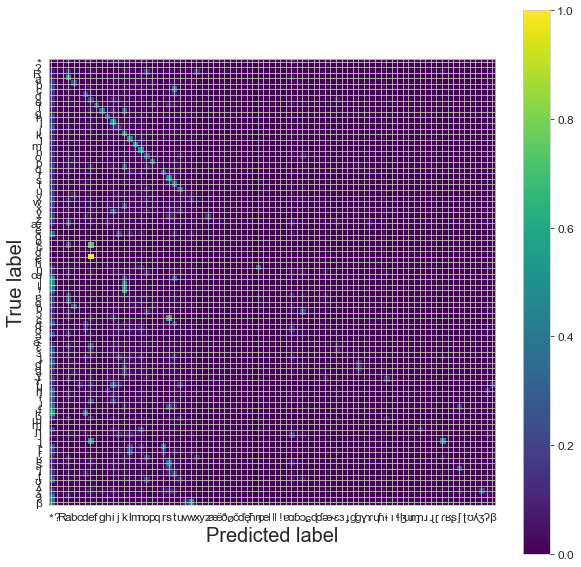

In [140]:
m = to_matrix(subset_df, log=False, norm=True, occ_thresh=occ_thresh, ref_field='ref', hyp_field='hyp')
_, ax = plt.subplots(figsize=(10, 10))
m.plot(include_values=False, ax=ax)

In [141]:
mtx = m.confusion_matrix
mtx.shape

(80, 80)

In [148]:
x = mtx[np.sum(mtx, axis=1) > 0]#.shape
print(x.shape)
y = x[:, np.sum(x, axis=0) > 0]
y.shape


(72, 80)


(72, 63)

In [147]:
(np.sum(x, axis=1) > 0).shape

(63,)

In [326]:
def build_dendrogram(
    subset_df,
    occ_thresh = 50,  # at least 50 occurrences of a confusion to count for this excercise (median of )
    remove_singletons: bool = True,
    ax = None,
    font_size: int = 20,
    color_threshold: float = 0.3
):
    m = to_matrix(subset_df, log=False, norm=True, occ_thresh=occ_thresh, ref_field='ref', hyp_field='hyp')
    mtx = m.confusion_matrix
    lbl = m.display_labels
    
    if remove_singletons:
        # Remove the asterisk which is always at the first index
        mtx = mtx[1:, 1:]
        lbl = lbl[1:]
        # Find the indices of rows ("ground truth phones") that have all zero columns ("predicted phones")
        # This can happen due to occurrence thresholding
        # We will remove these indices from the label set
        removed_indices = set(np.where(np.sum(mtx, axis=1) == 0)[0])
        # Remove the rows which have all zeros (ground truth phones that we discarded)
        mtx = mtx[np.sum(mtx, axis=1) > 0]
        # Remove the columns which have all zeros (predicted phones that never got recognized)
        mtx = mtx[:, np.sum(mtx, axis=0) > 0]
        lbl = [l for i, l in enumerate(lbl) if i not in removed_indices]
    
    # _, ax = plt.subplots(figsize=(10, 10))
    # m.plot(include_values=False, ax=ax)
    
    #metric = 'euclidean'  # L2
    #metric = lambda x, y: np.sum(np.abs(x - y))  # L1
#     metric = lambda x, y: np.max(np.abs(x - y))  # Linf
    metric = 'jensenshannon'
    D = scipy.spatial.distance.pdist(mtx, metric=metric)
    #D_orig = scipy.spatial.distance.squareform(D)
    #plt.matshow(D_orig)
    
    Z = scipy.cluster.hierarchy.linkage(D, optimal_ordering=True, method='weighted', metric=metric)
    
    if ax is None:
        _, ax = plt.subplots(figsize=(30, 10))
    ddg = scipy.cluster.hierarchy.dendrogram(Z, ax=ax, labels=lbl, distance_sort=True, leaf_font_size=font_size, leaf_rotation=0, color_threshold=color_threshold)    

/Users/pzelasko/jhu/alignysis/alignysis/confusions.py:41: RuntimeWarning:

invalid value encountered in true_divide



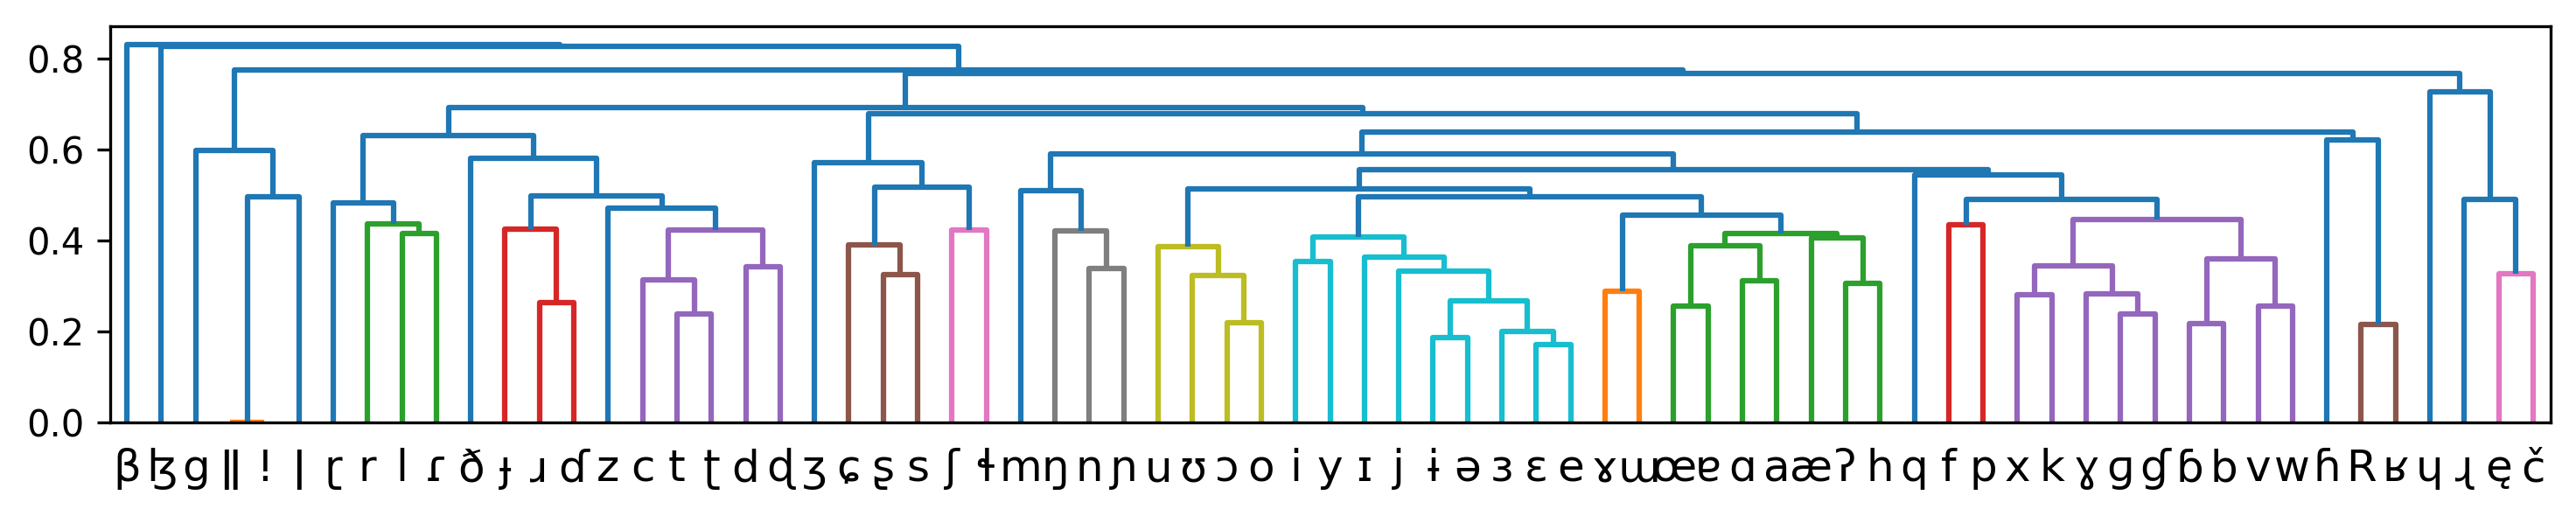

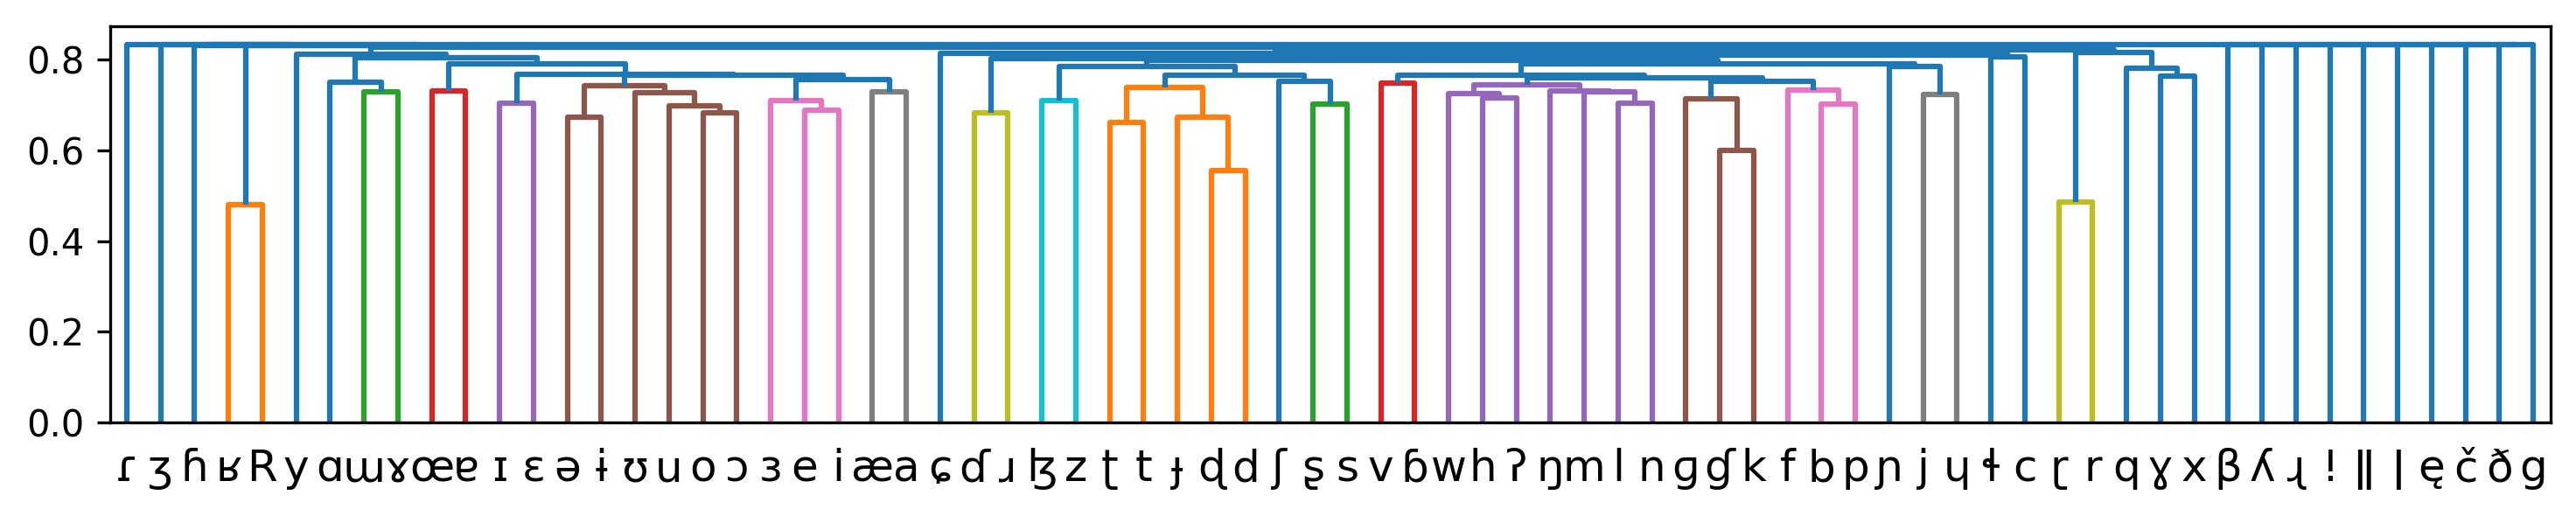

In [350]:
sns.reset_orig()
fig1, ax1 = plt.subplots(1, 1, figsize=(12, 2), dpi=300)
build_dendrogram(subset_df=confs.query('SYSTEM == "e2e_phones" & AM == "cross" & TOKEN_TYPE == "bper"'), ax=ax1, font_size=12, color_threshold=0.45)
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 2), dpi=300)
build_dendrogram(subset_df=confs.query('SYSTEM == "e2e_phones" & AM == "multi" & TOKEN_TYPE == "bper"'), ax=ax2, font_size=12, color_threshold=0.75)

# Path('figures').mkdir(exist_ok=True)
# fig1.savefig('figures/cross_dendrogram_e2e_basephones.pdf', dpi=300)
# fig2.savefig('figures/multi_dendrogram_e2e_basephones.pdf', dpi=300)

In [338]:
def plot_similarity_dendrogram(similarities, labels):
    # Source: https://plotly.com/python/dendrogram/
    # To display this in jupyter lab:
    # https://plotly.com/python/getting-started/#jupyterlab-support

    import plotly.graph_objects as go
    import plotly.figure_factory as ff
    from scipy.spatial.distance import pdist, squareform
    from scipy.cluster.hierarchy import linkage

    data = similarities

    # Initialize figure by creating upper dendrogram
    fig = ff.create_dendrogram(data, orientation='bottom', labels=labels,
                               distfun=partial(pdist, metric='jensenshannon'),
                               linkagefun=partial(linkage,
                                                  optimal_ordering=True,
                                                  method='weighted',
                                                  metric='jensenshannon'
                                                  )
                               )
    for i in range(len(fig['data'])):
        fig['data'][i]['yaxis'] = 'y2'

    # Create Side Dendrogram
    dendro_side = ff.create_dendrogram(data, orientation='right',
                               distfun=partial(pdist, metric='jensenshannon'),
                               linkagefun=partial(linkage,
                                                  optimal_ordering=True,
                                                  method='weighted',
                                                  metric='jensenshannon'
                                                  )
                               )
    # dendro_side = ff.create_dendrogram(data, orientation='right')
    for i in range(len(dendro_side['data'])):
        dendro_side['data'][i]['xaxis'] = 'x2'

    # Add Side Dendrogram Data to Figure
    for data_ in dendro_side['data']:
        fig.add_trace(data_)

    # Create Heatmap
    dendro_leaves = dendro_side['layout']['yaxis']['ticktext']
    dendro_leaves = list(map(int, dendro_leaves))
    data_dist = pdist(data, metric='jensenshannon')
    heat_data = squareform(data_dist)
    heat_data = heat_data[dendro_leaves, :]
    heat_data = heat_data[:, dendro_leaves]

    heatmap = [
        go.Heatmap(
            x=dendro_leaves,
            y=dendro_leaves,
            z=heat_data,
            colorscale='Blues'
        )
    ]

    heatmap[0]['x'] = fig['layout']['xaxis']['tickvals']
    heatmap[0]['y'] = fig['layout']['xaxis']['tickvals']
#     heatmap[0]['y'] = dendro_side['layout']['yaxis']['tickvals']

    # Add Heatmap Data to Figure
    for data_ in heatmap:
        fig.add_trace(data_)

    fig.update_layout({'width': 1300, 'height': 1300,
                       'showlegend': False, 'hovermode': 'closest',
                       })
    # Edit xaxis
    fig.update_layout(xaxis={'domain': [.15, 1],
                             'mirror': False,
                             'showgrid': False,
                             'showline': False,
                             'zeroline': False,
                             'ticks': ""})
    # Edit xaxis2
    fig.update_layout(xaxis2={'domain': [0, .15],
                              'mirror': False,
                              'showgrid': False,
                              'showline': False,
                              'zeroline': False,
                              'showticklabels': False,
                              'ticks': ""})

    # Edit yaxis
    fig.update_layout(yaxis={'domain': [0, .85],
                             'mirror': False,
                             'showgrid': False,
                             'showline': False,
                             'zeroline': False,
                             'showticklabels': True,
                             'ticks': ""
                             })
    # Edit yaxis2
    fig.update_layout(yaxis2={'domain': [.825, .975],
                              'mirror': False,
                              'showgrid': False,
                              'showline': False,
                              'zeroline': False,
                              'showticklabels': False,
                              'ticks': ""})

    # Plot!
    fig.show()


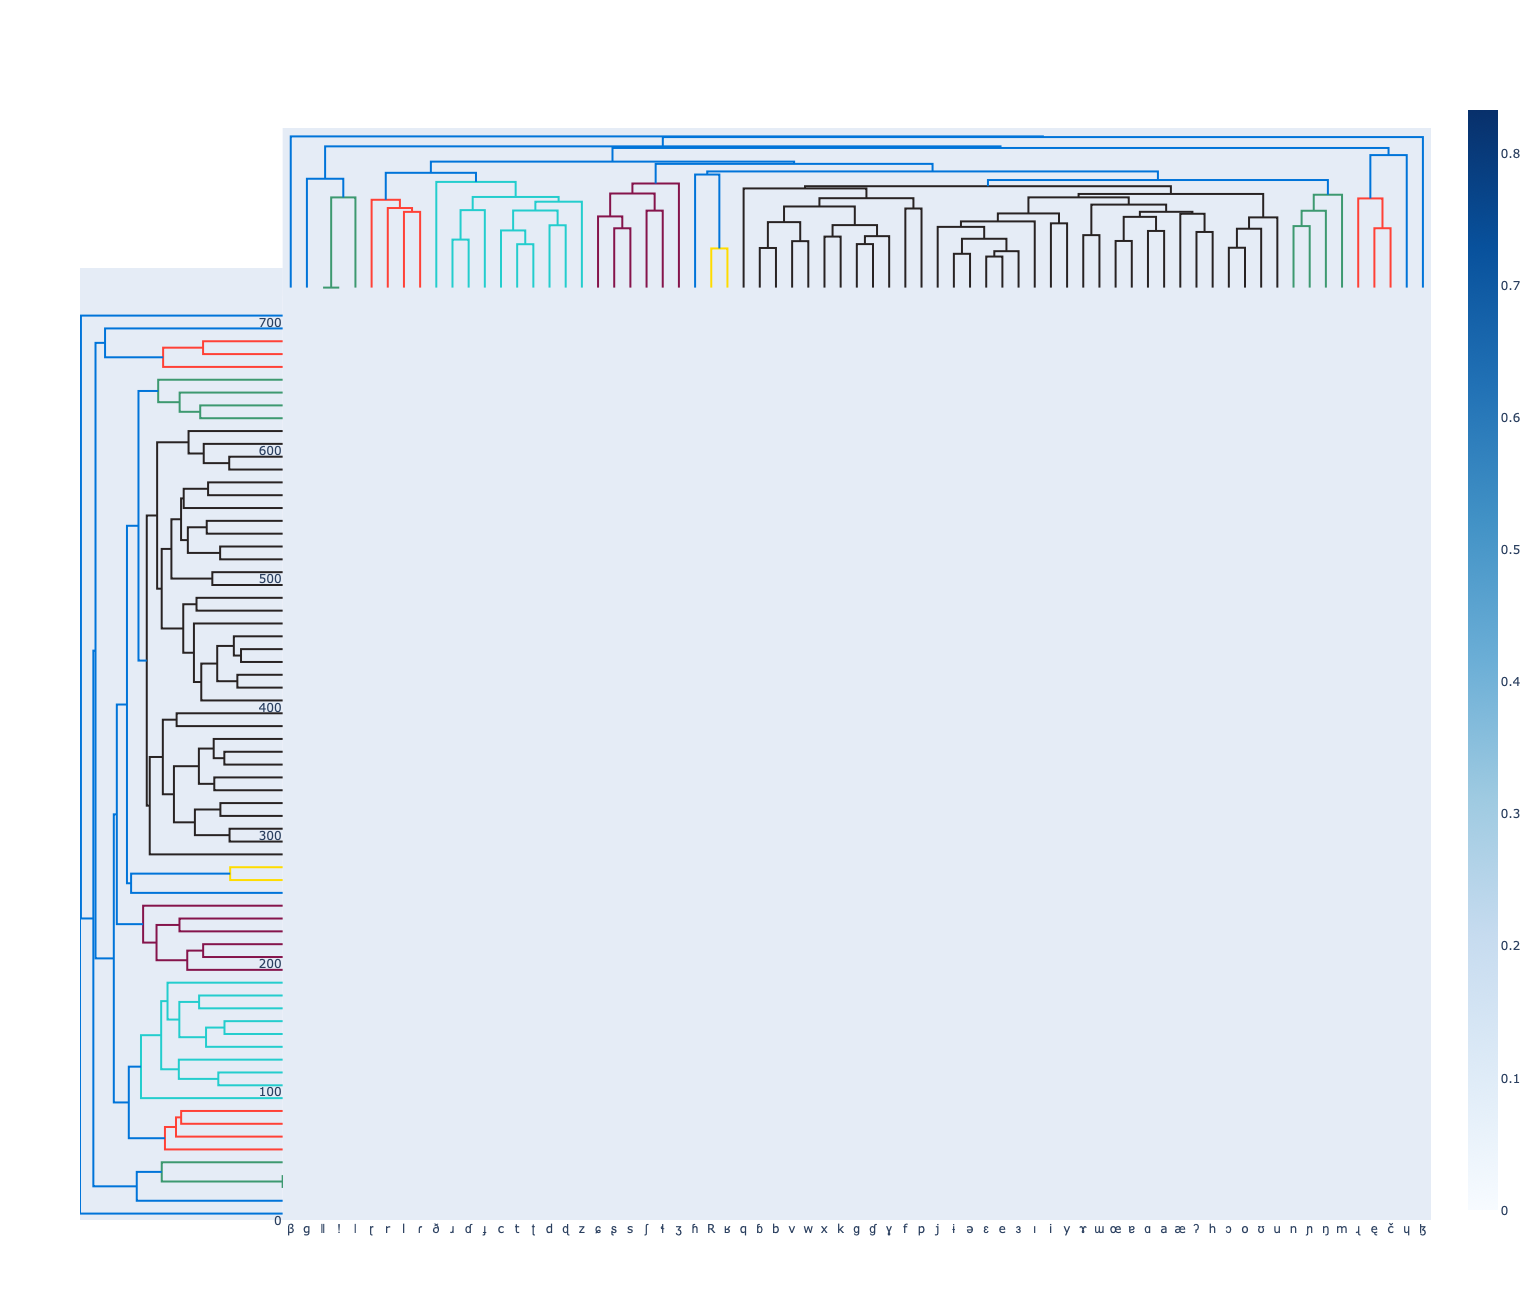

In [339]:
subset_df = confs.query('SYSTEM == "e2e_phones" & AM == "cross" & TOKEN_TYPE == "bper"')
m = to_matrix(subset_df, log=False, norm=True, occ_thresh=occ_thresh, ref_field='ref', hyp_field='hyp')
mtx = m.confusion_matrix
lbl = m.display_labels

# Remove the asterisk which is always at the first index
mtx = mtx[1:, 1:]
lbl = lbl[1:]
# Find the indices of rows ("ground truth phones") that have all zero columns ("predicted phones")
# This can happen due to occurrence thresholding
# We will remove these indices from the label set
removed_indices = set(np.where(np.sum(mtx, axis=1) == 0)[0])
# Remove the rows which have all zeros (ground truth phones that we discarded)
mtx = mtx[np.sum(mtx, axis=1) > 0]
# Remove the columns which have all zeros (predicted phones that never got recognized)
mtx = mtx[:, np.sum(mtx, axis=0) > 0]
lbl = [l for i, l in enumerate(lbl) if i not in removed_indices]

plot_similarity_dendrogram(mtx, lbl)

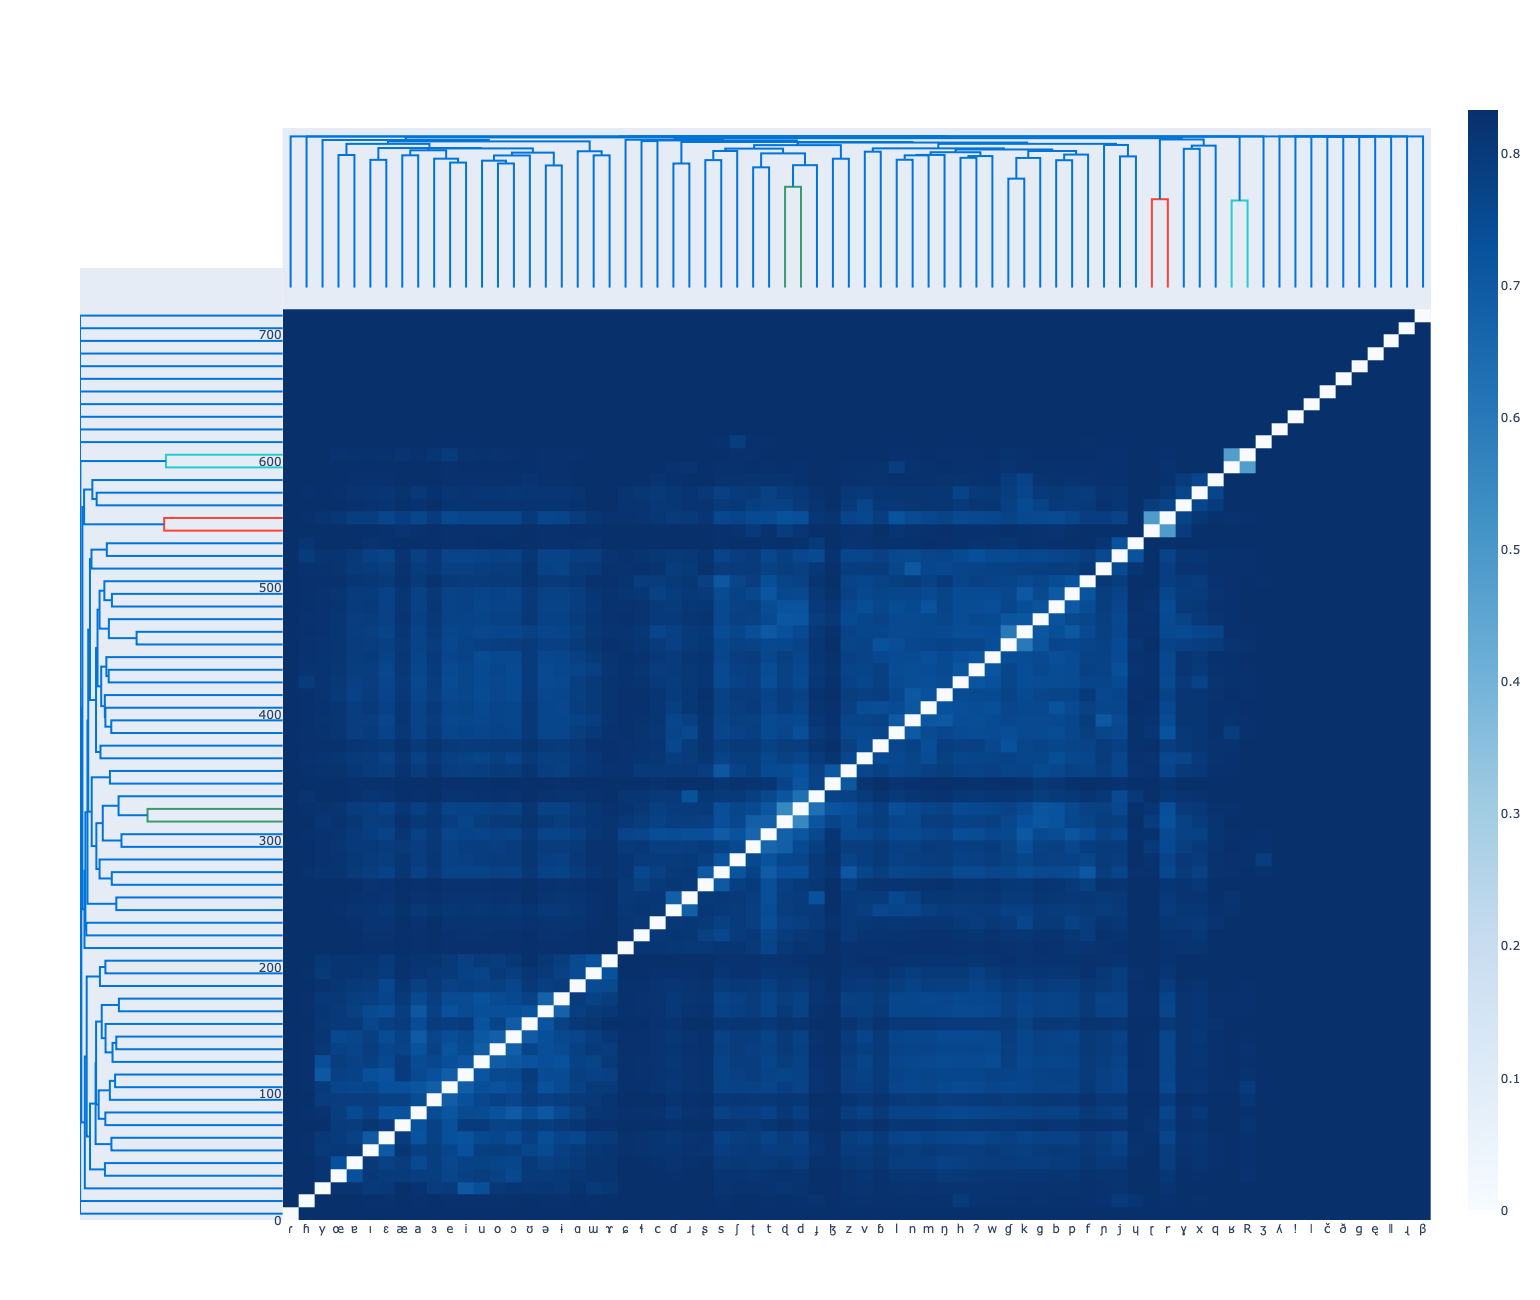

In [340]:
subset_df = confs.query('SYSTEM == "e2e_phones" & AM == "multi" & TOKEN_TYPE == "bper"')
m = to_matrix(subset_df, log=False, norm=True, occ_thresh=occ_thresh, ref_field='ref', hyp_field='hyp')
mtx = m.confusion_matrix
lbl = m.display_labels

# Remove the asterisk which is always at the first index
mtx = mtx[1:, 1:]
lbl = lbl[1:]
# Find the indices of rows ("ground truth phones") that have all zero columns ("predicted phones")
# This can happen due to occurrence thresholding
# We will remove these indices from the label set
removed_indices = set(np.where(np.sum(mtx, axis=1) == 0)[0])
# Remove the rows which have all zeros (ground truth phones that we discarded)
mtx = mtx[np.sum(mtx, axis=1) > 0]
# Remove the columns which have all zeros (predicted phones that never got recognized)
mtx = mtx[:, np.sum(mtx, axis=0) > 0]
lbl = [l for i, l in enumerate(lbl) if i not in removed_indices]

plot_similarity_dendrogram(mtx, lbl)

In [374]:
sns.color_palette(n_colors=13)

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]

<module 'matplotlib.markers' from '/Users/pzelasko/miniconda3/envs/lhotse38/lib/python3.8/site-packages/matplotlib/markers.py'>

In [418]:
subset_df = confs.query('SYSTEM == "e2e_phones" & AM == "cross" & TOKEN_TYPE == "bper"')
m = to_matrix(subset_df, log=False, norm=True, occ_thresh=occ_thresh, ref_field='ref', hyp_field='hyp')
mtx = m.confusion_matrix
lbl = m.display_labels

# Remove the asterisk which is always at the first index
mtx = mtx[1:, 1:]
lbl = lbl[1:]
# Find the indices of rows ("ground truth phones") that have all zero columns ("predicted phones")
# This can happen due to occurrence thresholding
# We will remove these indices from the label set
removed_indices = set(np.where(np.sum(mtx, axis=1) == 0)[0])
# Remove the rows which have all zeros (ground truth phones that we discarded)
mtx = mtx[np.sum(mtx, axis=1) > 0]
# Remove the columns which have all zeros (predicted phones that never got recognized)
mtx = mtx[:, np.sum(mtx, axis=0) > 0]
lbl = [l for i, l in enumerate(lbl) if i not in removed_indices]

metric = lambda x, y: np.max(np.abs(x - y))  # Linf
D = scipy.spatial.distance.pdist(mtx, metric=metric)
D = scipy.spatial.distance.squareform(D)

mnr = [phone_to_manner.get(l) for l in lbl]


import matplotlib.colors as mcolors

color_map = {
    m: c
    for m, c in zip(
        set(mnr),
        sns.color_palette(n_colors=len(set(mnr)))
    )
}
inv_cmap = {v: k for k, v in color_map.items()}
mnr_c = [color_map[m] for m in mnr]

marker_map = {
    m: mrkr for m, mrkr in zip(set(mnr), '.ov^<>8spP*h+HxXDd1234')
}
inv_cmap = {v: k for k, v in marker_map.items()}
mnr_m = [marker_map[m] for m in mnr]

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
import numba

sns.set(style='white', context='poster')#, rxc={'figure.figsize':(14,10)})
# sns.reset_orig()

@numba.njit()
def linf(a,b):
    return np.max(np.abs(a - b))


def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(mtx);
    colors = []
    
    fig = plt.figure(figsize=(20, 14))
    
    if n_components == 1:
        ax = fig.add_subplot(111)
        scatter = ax.scatter(u[:,0], range(len(u)), c=mnr_c)
        
    if n_components == 2:
        
        data = pd.DataFrame({
            'x': u[:, 0],
            'y': u[:, 1],
            'label': lbl,
            'manner': mnr,
            'color': mnr_c,
            'marker': mnr_m
        })
        
        ax = fig.add_subplot(111)
        scatters = []
        for manner in data.manner.unique():
            part = data.query(f'manner == "{manner}"')
            scatters.append(
                ax.scatter(part['x'], part['y'], c=color_map[manner], marker=marker_map[manner], label=manner)
            )
        x_width = np.max(u[:, 0]) - np.min(u[:, 0])
        y_width = np.max(u[:, 1]) - np.min(u[:, 1])
        for i, l in enumerate(lbl):
            ax.annotate(l, (u[i, 0] + 0.01 * x_width, u[i, 1] + 0.01 * y_width), fontsize=18)
            
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(u[:,0], u[:,1], u[:,2], s=100, c=mnr_c)
        for i, l in enumerate(lbl):
            ax.annotate(l, (u[i, 0], u[i, 1], u[i, 2]), fontsize=16)
            
    ax.legend(title='Manner:', framealpha=0.5, fontsize=14, loc="lower left")

    if title is not None and title:
        plt.title(title, fontsize=18)
        
    return fig

/Users/pzelasko/jhu/alignysis/alignysis/confusions.py:41: RuntimeWarning:

invalid value encountered in true_divide



/Users/pzelasko/miniconda3/envs/lhotse38/lib/python3.8/site-packages/umap/umap_.py:1727: UserWarning:

custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])

2021-02-17 15:04:26,511 WARNING [_axes.py:4280] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
2021-02-17 15:04:26,514 WARNING [_axes.py:4280] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if y

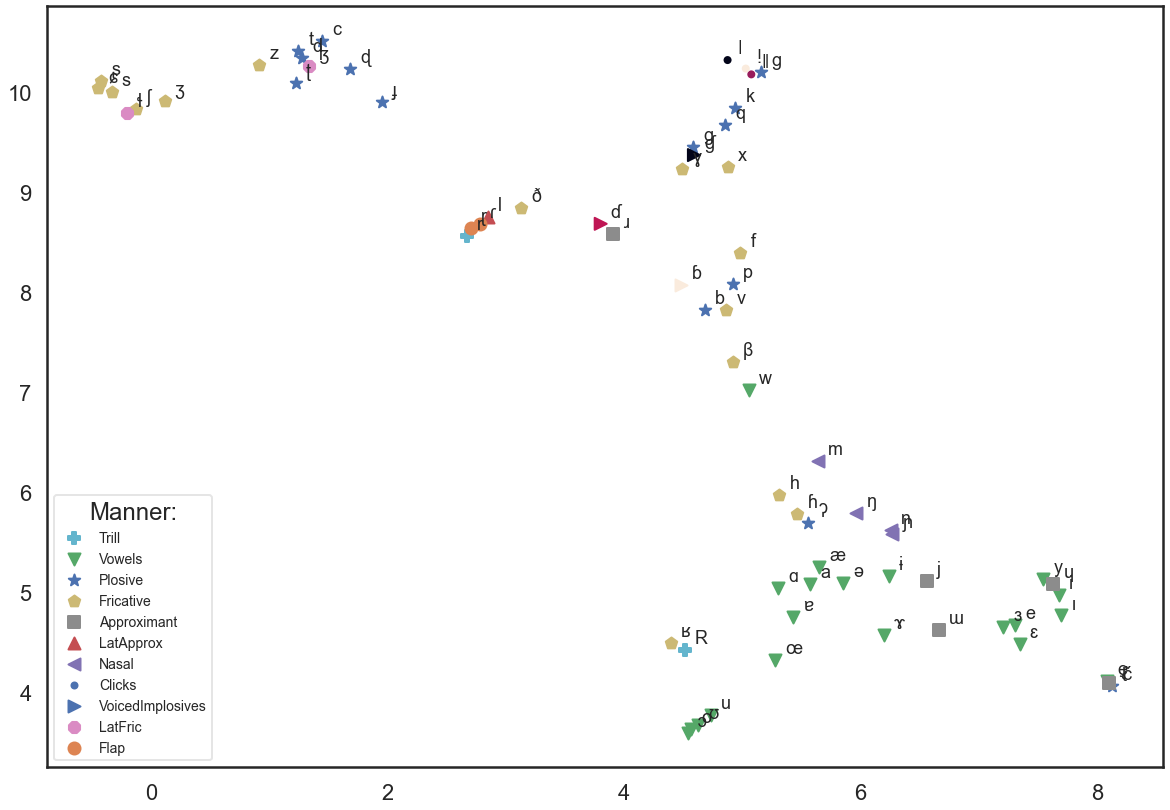

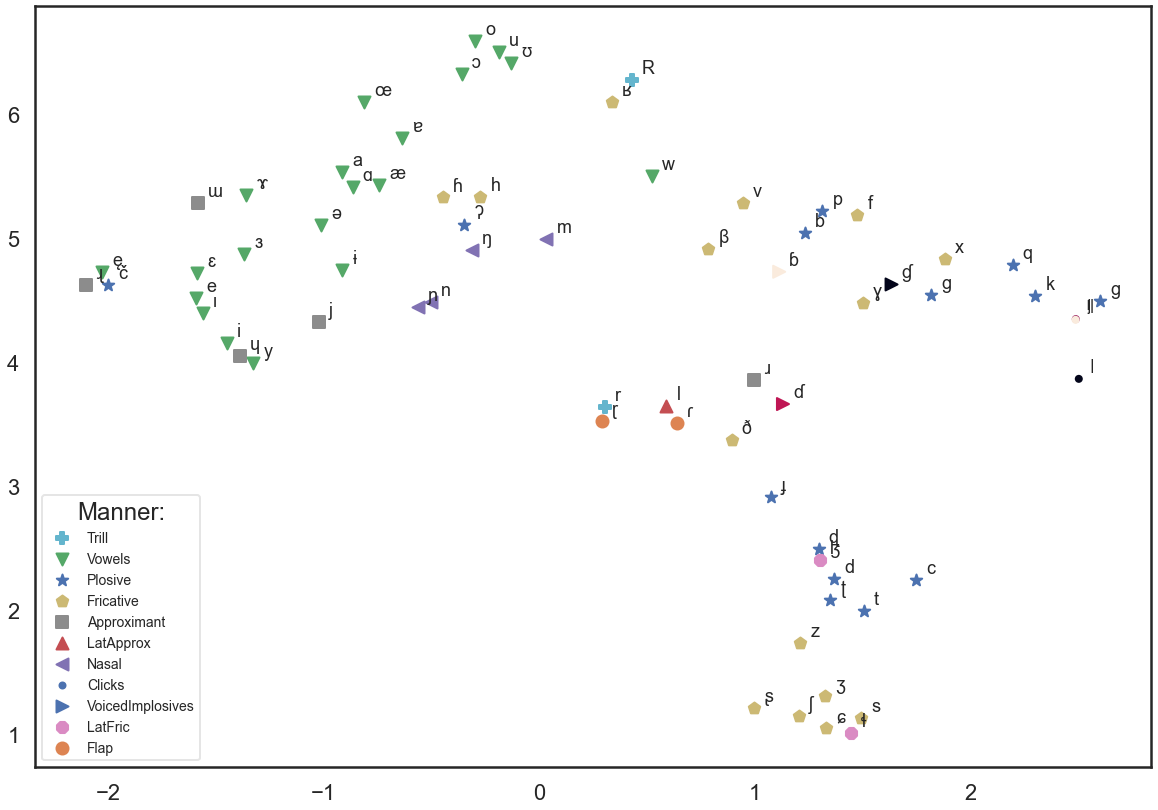

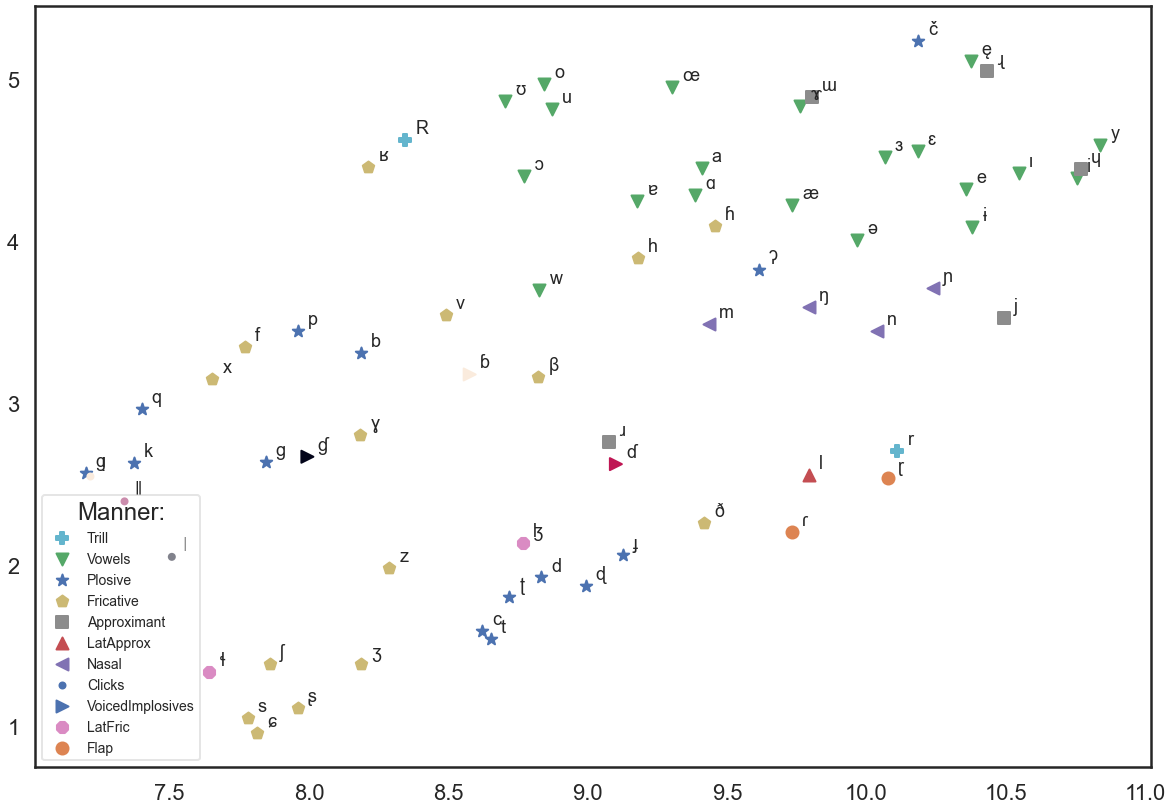

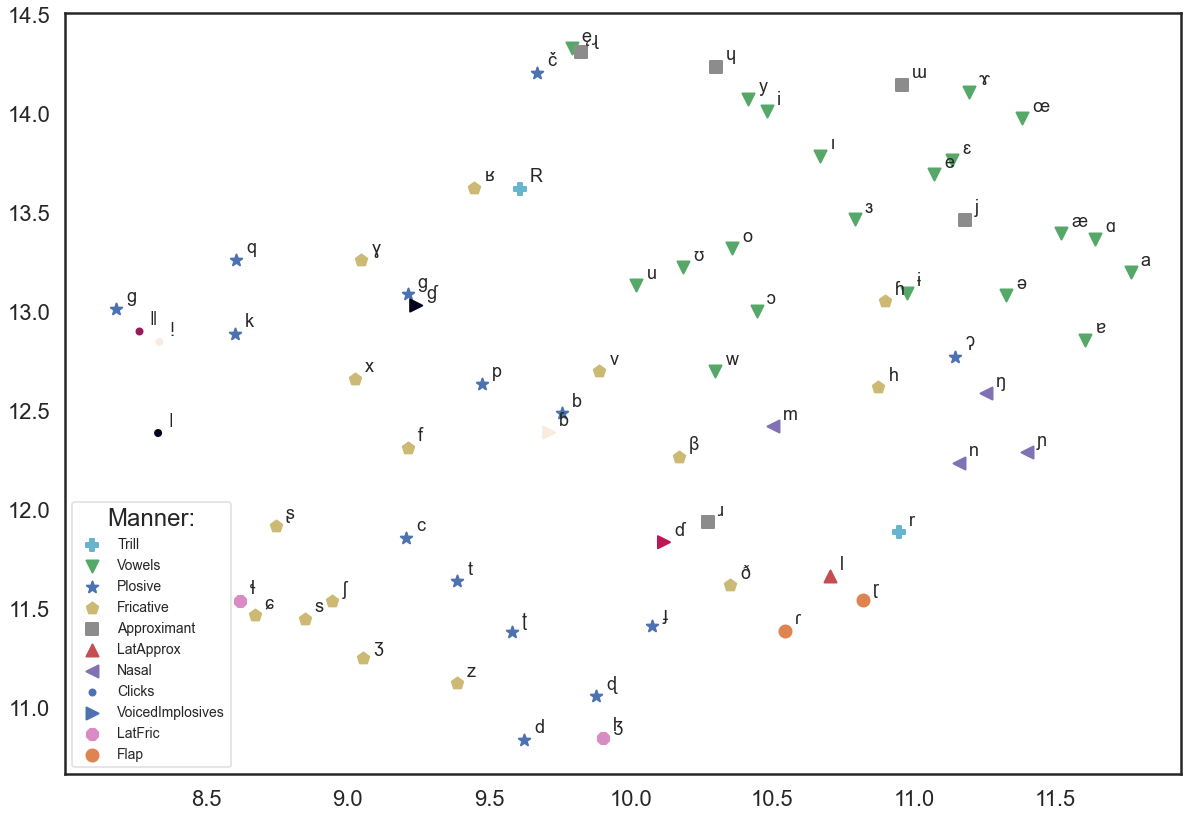

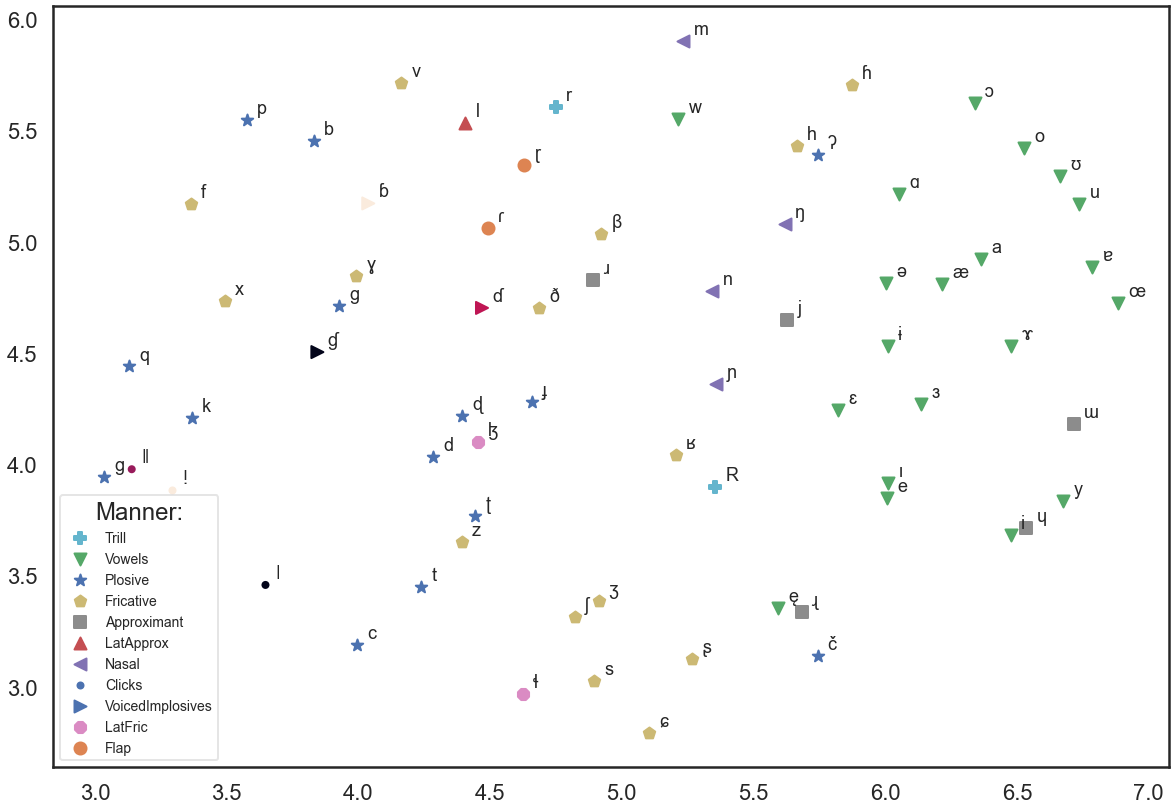

In [419]:
umap_figs = []
for n in (5, 10, 20, 50, 100):
    umap_figs += [draw_umap(
        n_neighbors=n, 
        min_dist=0.0, 
        #min_dist=0.1, 
        #metric=linf, 
        metric=jensenshannon,
        #title='UMAP projection of the phone confusion matrix (n_neighbors = {})'.format(n)
    )]

In [420]:
umap_figs[-1].savefig('figures/cross_umap_phone_conf_mtx.pdf', dpi=300)

In [323]:
subset_df = confs.query('EXP == "hybrid_phones_cross_crosslm_bper"')
m = to_matrix(subset_df, log=False, norm=True, occ_thresh=occ_thresh, ref_field='ref', hyp_field='hyp')
mtx = m.confusion_matrix
lbl = m.display_labels

# Find the indices of rows ("ground truth phones") that have all zero columns ("predicted phones")
# This can happen due to occurrence thresholding
# We will remove these indices from the label set
removed_indices = set(np.where(np.sum(mtx, axis=1) == 0)[0])
# Remove the rows which have all zeros (ground truth phones that we discarded)
mtx = mtx[np.sum(mtx, axis=1) > 0]
# Remove the columns which have all zeros (predicted phones that never got recognized)
mtx = mtx[:, np.sum(mtx, axis=0) > 0]
lbl = [l for i, l in enumerate(lbl) if i not in removed_indices]

metric = lambda x, y: np.max(np.abs(x - y))  # Linf
D = scipy.spatial.distance.pdist(mtx, metric=metric)
D = scipy.spatial.distance.squareform(D)

mnr = [phone_to_manner.get(l) for l in lbl]

set(mnr)

import matplotlib.colors as mcolors

color_map = {
    m: c
    for m, c in zip(
        set(mnr),
        range(100)
    )
}
inv_cmap = {v: k for k, v in color_map.items()}

mnr_c = [color_map[m] for m in mnr]

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
import numba

sns.set(style='white', context='poster')#, rc={'figure.figsize':(14,10)})
#sns.reset_orig()

@numba.njit()
def linf(a,b):
    return np.max(np.abs(a - b))


from scipy.spatial.distance import jensenshannon

def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(mtx);
    colors = []
    fig = plt.figure(figsize=(20, 14))
    if n_components == 1:
        ax = fig.add_subplot(111)
        scatter = ax.scatter(u[:,0], range(len(u)), c=mnr_c)
    if n_components == 2:
        ax = fig.add_subplot(111)
        scatter = ax.scatter(u[:,0], u[:,1], c=mnr_c)
        x_width = np.max(u[:, 0]) - np.min(u[:, 0])
        y_width = np.max(u[:, 1]) - np.min(u[:, 1])
        for i, l in enumerate(lbl):
            ax.annotate(l, (u[i, 0] + 0.01 * x_width, u[i, 1] + 0.01 * y_width), fontsize=16)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(u[:,0], u[:,1], u[:,2], s=100, c=mnr_c)
        for i, l in enumerate(lbl):
            ax.annotate(l, (u[i, 0], u[i, 1], u[i, 2]), fontsize=16)
    
    # produce a legend with the unique colors from the scatter
    actors, labels = scatter.legend_elements()
    import re 
    parse = lambda l: int(re.search(r'\d+', l).group(0))
    labels = [inv_cmap[parse(l)] for l in labels]
    legend1 = ax.legend(actors, labels,
                        loc="lower left", title="Classes")
    ax.add_artist(legend1)

    plt.title(title, fontsize=18)

/Users/pzelasko/jhu/alignysis/alignysis/confusions.py:41: RuntimeWarning: invalid value encountered in true_divide
  mtx = (mtx.T / den).T


/Users/pzelasko/miniconda3/envs/lhotse38/lib/python3.8/site-packages/umap/umap_.py:1727: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(
/Users/pzelasko/miniconda3/envs/lhotse38/lib/python3.8/site-packages/umap/umap_.py:1727: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(
/Users/pzelasko/miniconda3/envs/lhotse38/lib/python3.8/site-packages/umap/umap_.py:1727: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.ar

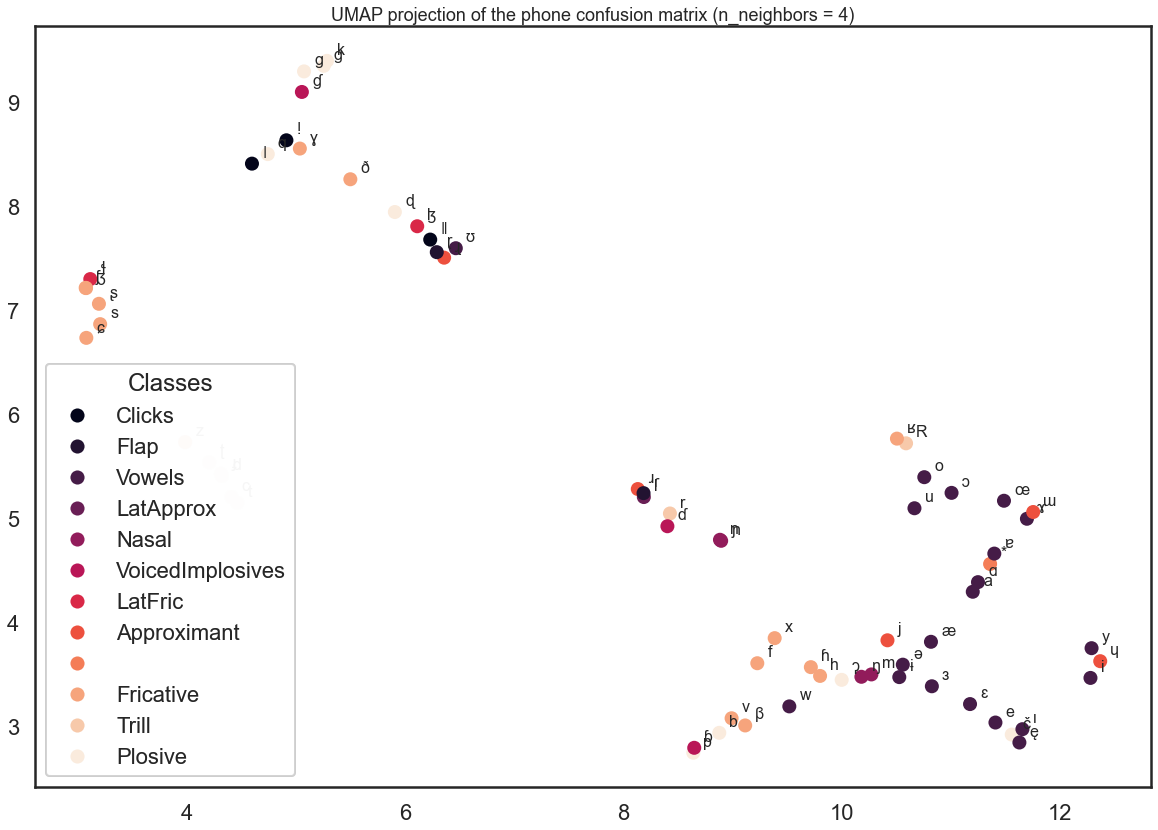

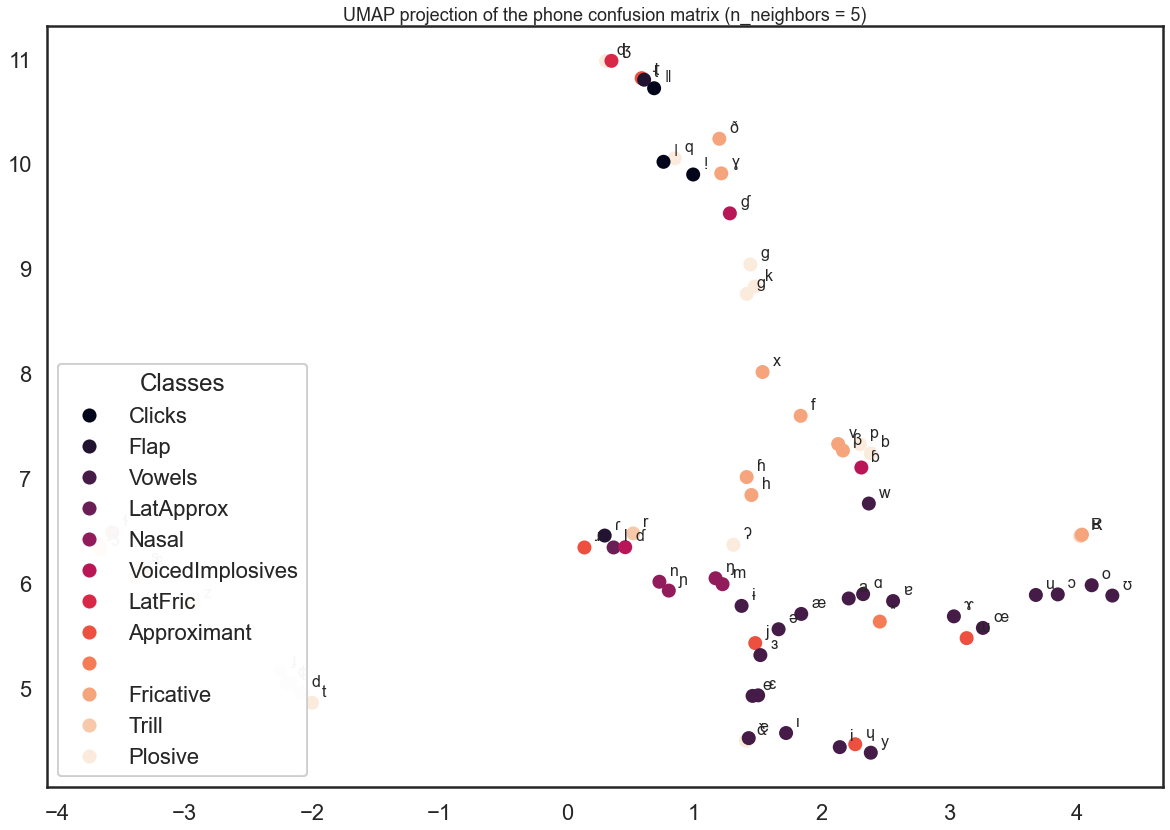

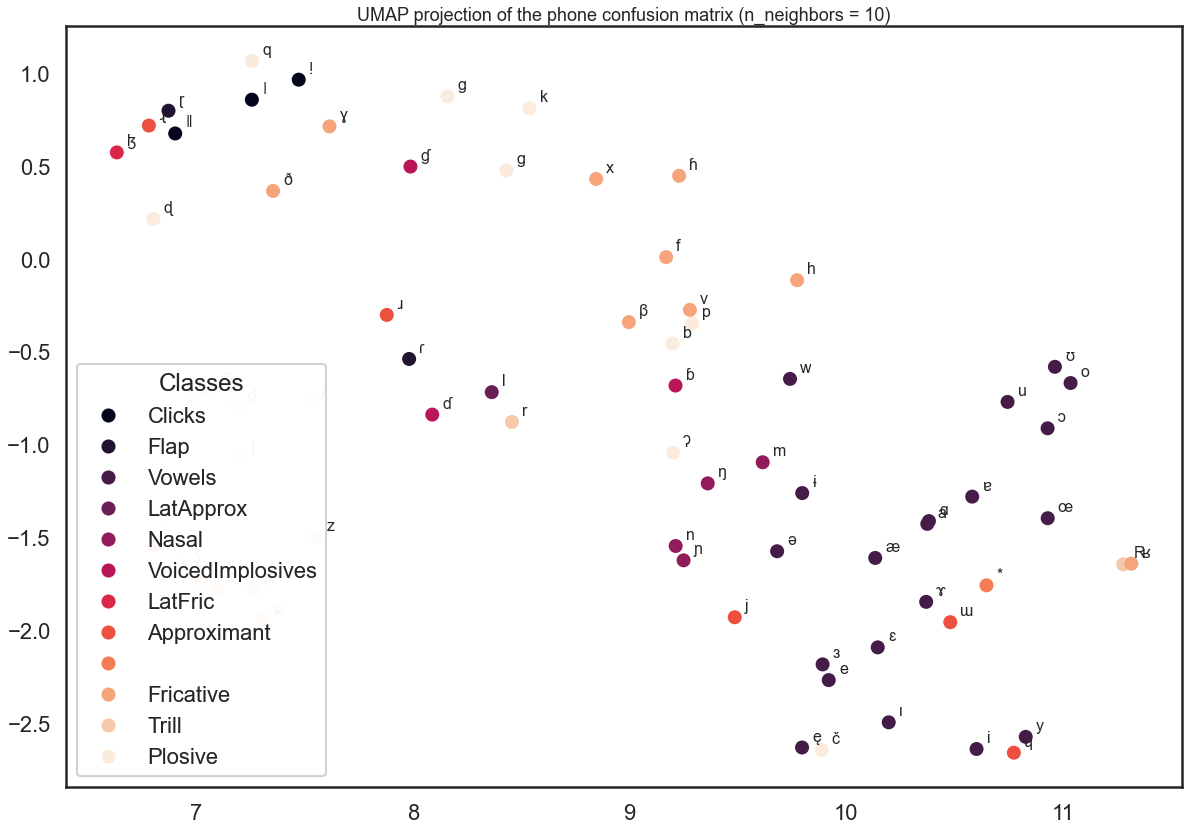

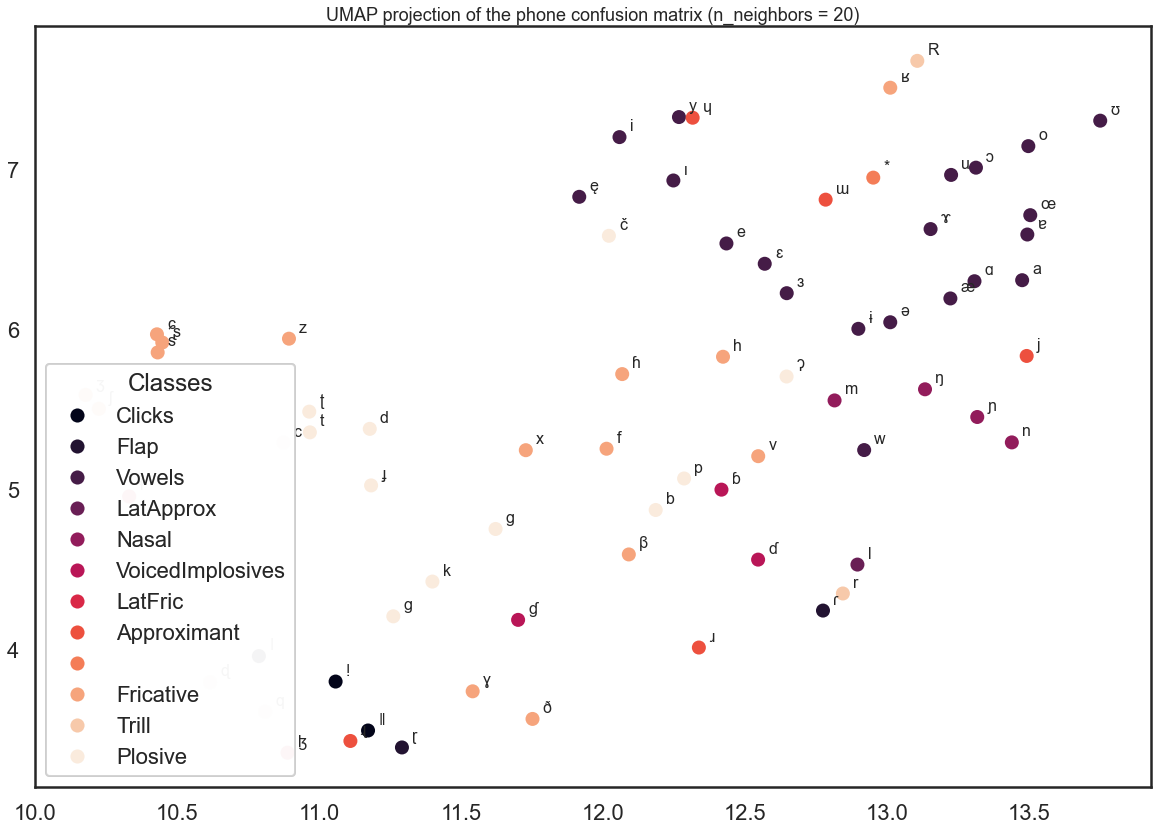

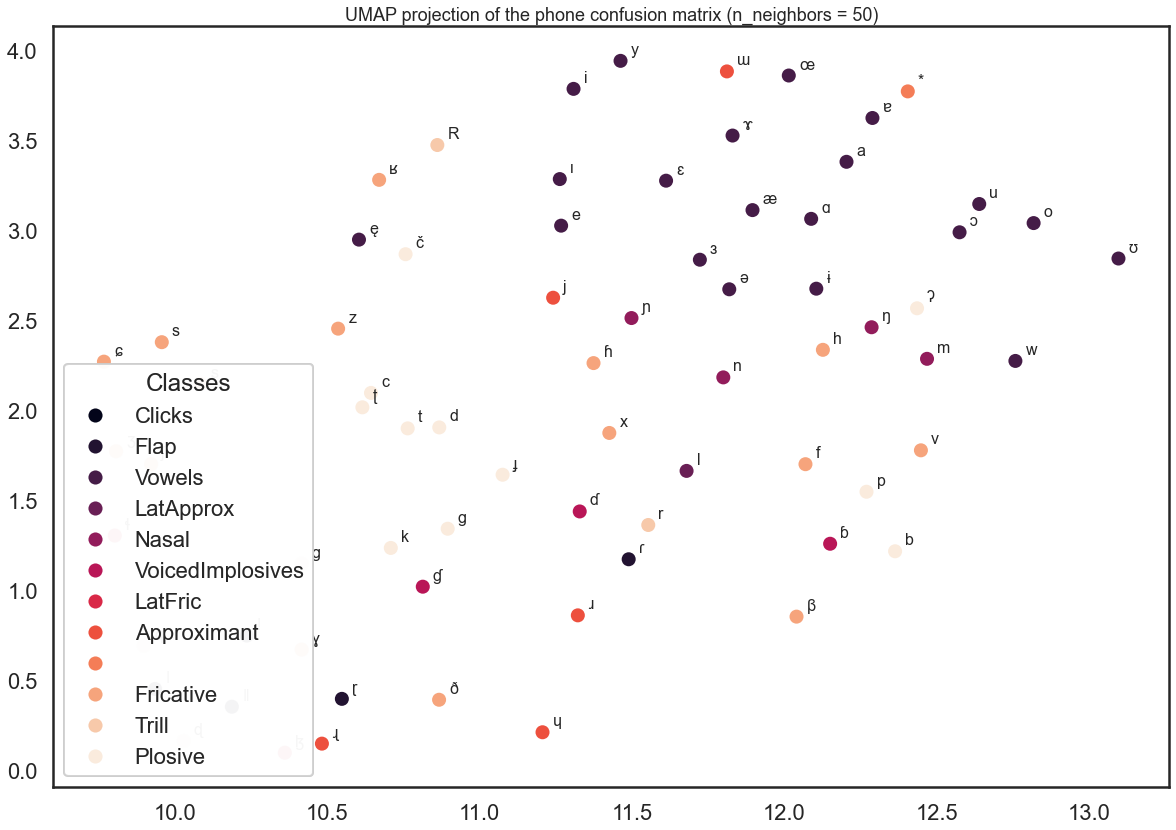

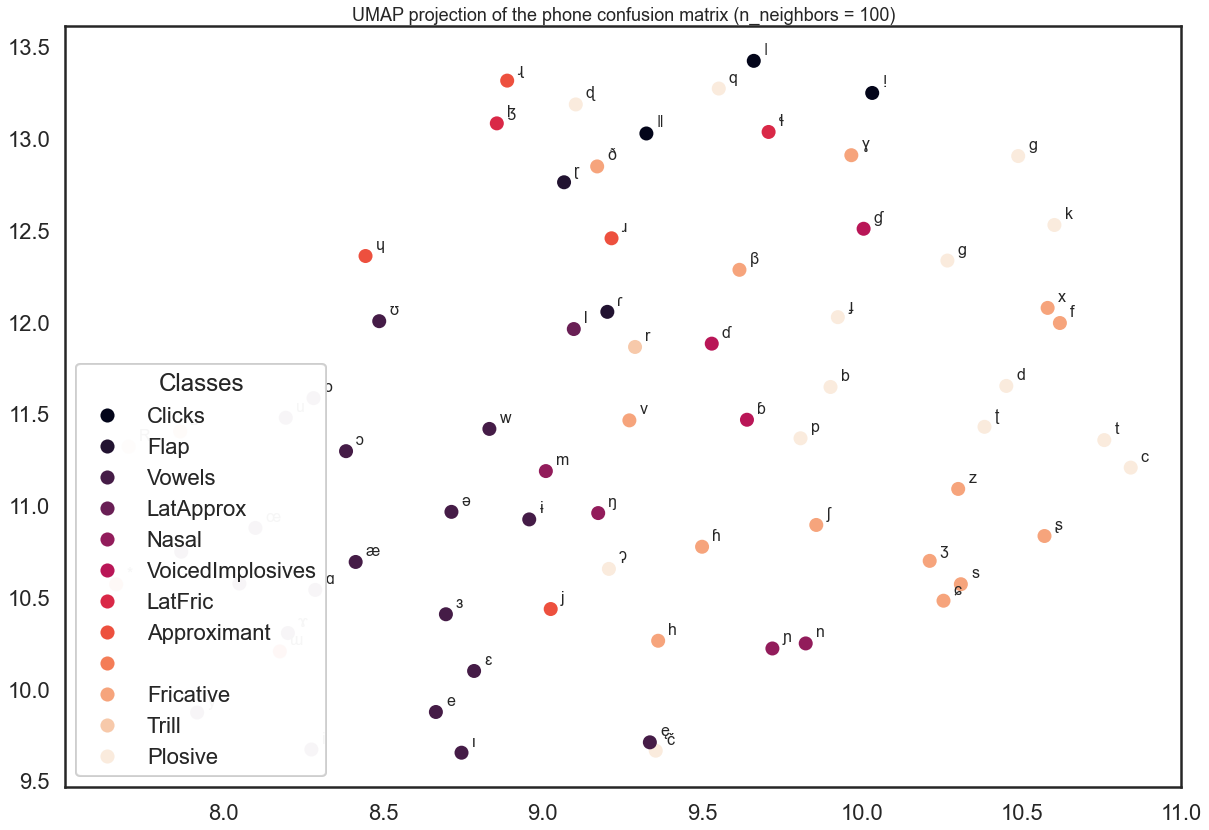

In [324]:
for n in (4, 5, 10, 20, 50, 100):
    draw_umap(
        n_neighbors=n, 
        min_dist=0.0, 
        #min_dist=0.1, 
        #metric=linf, 
        metric=jensenshannon,
        title='UMAP projection of the phone confusion matrix (n_neighbors = {})'.format(n)
    )

In [297]:
import networkx as nx
from math import isinf

C = nx.DiGraph()

for i, ilbl in enumerate(lbl):
    for j, jlbl in enumerate(lbl):
        w = mtx[i, j] + 0.0000001
        if isinf(w) or w < 0.01:
            continue
        C.add_edge(ilbl, jlbl, weight=1 / w)

from matplotlib import pyplot as plt

plt.figure(figsize=(10,6))
pos = nx.spring_layout(C, k=0.8)
nx.draw(C, pos , with_labels = True, width=0.4, 
        node_color='lightblue', node_size=400)

NameError: name 'networkx' is not defined

<AxesSubplot:xlabel='token'>

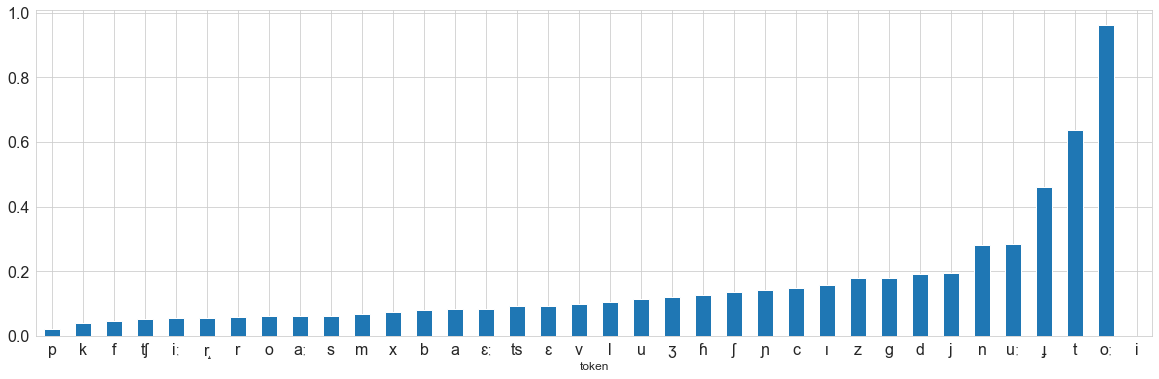

In [8]:
(
    df
    .query('SYSTEM == "e2e_phones" & AM == "multi" & TOKEN_TYPE == "per" & LANG == "Czech"')
    .assign(ERR=lambda row: (row.INSERTION + row.DELETION + row.SUBSTITUTION) / (row.TOTAL_TRUE_COUNT + 1))
    .set_index('token')
    .sort_values('ERR')
    .ERR
    .plot.bar(figsize=(20, 6), rot=0, fontsize=16)
)

In [27]:
df.LM.unique()

array([None, 'monolm_phn_ug', 'monolm_words_tg', 'monolm',
       'monolm_phn_tg', 'multilm_phn_ug', 'multiwordslm', 'multilm',
       'multilm_words_tg', 'multilm_phn_tg', 'crosslm_phn_ug', 'crosslm',
       'crosslm_words_tg', 'monolm_lowerbound', 'crosslm_phn_tg'],
      dtype=object)

<AxesSubplot:xlabel='token'>

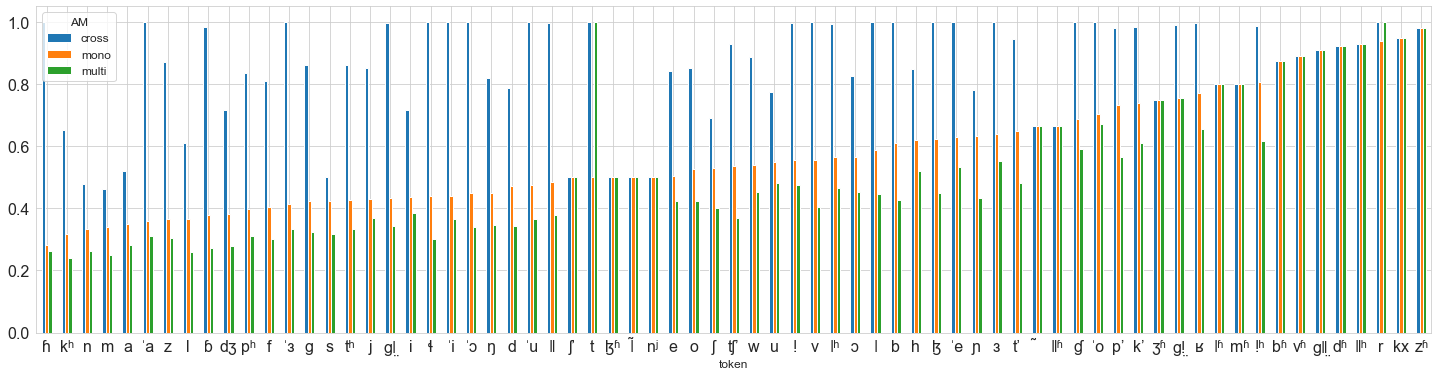

In [41]:
(
    df
#      .query('SYSTEM == "e2e_phones" & TOKEN_TYPE == "per" & LANG == "French"')
         .query('SYSTEM == "e2e_phones" & TOKEN_TYPE == "per" & LANG == "Zulu"')
#    .query('SYSTEM == "hybrid_phones" & (LM == "monolm" | LM == "crosslm") & TOKEN_TYPE == "per" & LANG == "French"')
#     .query('SYSTEM == "hybrid_phones" & (LM == "monolm" | LM == "crosslm") & TOKEN_TYPE == "per" & LANG == "Cantonese"')
    .assign(ERR=lambda row: (row.INSERTION + row.DELETION + row.SUBSTITUTION) / (row.TOTAL_TRUE_COUNT + 1))
    .set_index(['AM', 'token'])
    .ERR
    .unstack(0)
    .sort_values('mono')
    .dropna()
    .clip(upper=1.0)
#     .query('mono < 0.5 & cross > 0.9')
    .plot.bar(figsize=(25, 6), rot=0, fontsize=16)
)

In [43]:
(
    df
#      .query('SYSTEM == "e2e_phones" & TOKEN_TYPE == "per" & LANG == "French"')
         .query('SYSTEM == "e2e_phones" & TOKEN_TYPE == "per" & LANG == "Zulu"')
#    .query('SYSTEM == "hybrid_phones" & (LM == "monolm" | LM == "crosslm") & TOKEN_TYPE == "per" & LANG == "French"')
#     .query('SYSTEM == "hybrid_phones" & (LM == "monolm" | LM == "crosslm") & TOKEN_TYPE == "per" & LANG == "Cantonese"')
    .assign(ERR=lambda row: (row.INSERTION + row.DELETION + row.SUBSTITUTION) / (row.TOTAL_TRUE_COUNT + 1))
    .sort_values('token')
)

,token,TOTAL_TRUE_COUNT,OK,SUBSTITUTION,DELETION,INSERTION,LANG,SYSTEM,AM,LM,TOKEN_TYPE,EXP,ERR
11,a,34650.0,27063.0,5031.0,2556.0,2139.0,Zulu,e2e_phones,multi,None,per,e2e_phones_multi_None_per,0.280685
12,a,34650.0,17226.0,12352.0,5072.0,587.0,Zulu,e2e_phones,cross,None,per,e2e_phones_cross_None_per,0.519783
11,a,34650.0,25135.0,6938.0,2577.0,2568.0,Zulu,e2e_phones,mono,None,per,e2e_phones_mono_None_per,0.348706
202,aːɪ˧˨ʔ,NaN,NaN,NaN,NaN,1.0,Zulu,e2e_phones,cross,None,per,e2e_phones_cross_None_per,NaN
200,aːʊ˧,NaN,NaN,NaN,NaN,1.0,Zulu,e2e_phones,cross,None,per,e2e_phones_cross_None_per,NaN
167,aːʊ˧˥,NaN,NaN,NaN,NaN,1.0,Zulu,e2e_phones,cross,None,per,e2e_phones_cross_None_per,NaN
185,aː˧,NaN,NaN,NaN,NaN,1.0,Zulu,e2e_phones,cross,None,per,e2e_phones_cross_None_per,NaN
81,aː˧,NaN,NaN,NaN,NaN,1.0,Zulu,e2e_phones,multi,None,per,e2e_phones_multi_None_per,NaN
168,aː˧ʔ˥,NaN,NaN,NaN,NaN,1.0,Zulu,e2e_phones,cross,None,per,e2e_phones_cross_None_per,NaN
79,aː˧˥,NaN,NaN,NaN,NaN,1.0,Zulu,e2e_phones,multi,None,per,e2e_phones_multi_None_per,NaN


In [10]:
confs.ref.unique()

array(['w', 'ɐ', 'j', '˧', '˥', 'h', 'ɔ', 'ː', '˨', '*', 's', 'n', 'a',
       'd', 'o', 'z', 'm', 't', 'ɛ', '˩', 'i', 'k', 'f', 'e', 'ɡ', 'b',
       'ŋ', 'œ', 'y', 'l', 'u', 'p', 'ʰ', 'ɪ', 'æ', 'ʃ', '̃', 'ʈ', 'r',
       'ʒ', 'ɽ', 'ə', 'ɖ', 'v', 'ɗ', 'ɨ', 'ʔ', 'ɹ', 'ɓ', 'ɕ', 'x', 'ʊ',
       'ɣ', 'ʂ', 'ɲ', 'ɟ', 'c', 'ɑ', 'ɤ', 'ɯ', 'ˈ', 'ɜ', 'ǃ', 'ʼ', 'ɦ',
       'ɬ', 'ɮ', 'ɠ', 'ǀ', 'ʁ', '̤', 'ǁ', 'ʱ', 'ʲ', 'ʷ', 'ħ', 'q', '̝',
       'R', 'ø', 'ɥ', 'ę', 'g', 'č', 'ű', 'ů', 'ŕ', 'ď', 'ë', '˦', 'ɻ',
       'ɚ', '一', 'ɾ', 'β', 'ð', 'ʎ', 'ɱ', 'á', 'ó', '?', 'ɐj˧˥', 'ɔː˨',
       'ɐ˥', 'aː˥', 'ow˨', 'dz', 'ɛː˩˧', 'iː˨', 'ɔː˧˥', 'aː˨', 'ej˨',
       'ɐ˧', 'aːj˧', 'ow˥', 'ɔː˥', 'ow˧˥', 'ɔː˧', 'iː˨˩', 'ɐj˨', 'ej˧˥',
       'm˨˩', 'ɔː˩˧', 'œː˨', 'iː˥', 'ej˨˩', 'iː˩˧', 'œy˧', 'aː˧', 'ɡw',
       'ow˩˧', 'œy˩˧', 'aː˨˩', 'ow˧', 'ɐw˧', 'ɐw˨', 'ɔːj˧', 'aː˧˥',
       'yː˨˩', 'ɐ˧˥', 'ts', 'ɐ˨', 'ɐ˨˩', 'ɐw˩˧', 'iw˧˥', 'aːw˧˥', 'ej˧',
       'ɐj˨˩', 'iː˧', 'yː˥', 'uː˨', 'ɔːj˧˥', 'ɛː˨', 'aː˩˧', 'ɐw˧˥',


In [11]:
confs.query("count > 0 & SYSTEM == 'e2e_phones' & AM == 'mono'")

,ref,hyp,count,total_ref,lang,SYSTEM,AM,LM,TOKEN_TYPE,EXP,ref_place,hyp_place,ref_manner,hyp_manner
0,w,w,3050,4131,Cantonese,e2e_phones,mono,None,per,e2e_phones_mono_None_per,Vow-Cl,Vow-Cl,Vowels,Vowels
1,w,*,382,4131,Cantonese,e2e_phones,mono,None,per,e2e_phones_mono_None_per,Vow-Cl,*,Vowels,*
2,w,d,20,4131,Cantonese,e2e_phones,mono,None,per,e2e_phones_mono_None_per,Vow-Cl,Alveolar,Vowels,Plosive
3,w,ɡ,66,4131,Cantonese,e2e_phones,mono,None,per,e2e_phones_mono_None_per,Vow-Cl,Velar,Vowels,Plosive
4,w,n,14,4131,Cantonese,e2e_phones,mono,None,per,e2e_phones_mono_None_per,Vow-Cl,Alveolar,Vowels,Nasal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,j,a,2,11,Thai,e2e_phones,mono,None,bper,e2e_phones_mono_None_bper,Palatal,Vow-Open,Approximant,Vowels
379,j,j,2,11,Thai,e2e_phones,mono,None,bper,e2e_phones_mono_None_bper,Palatal,Palatal,Approximant,Approximant
380,j,ʔ,1,11,Thai,e2e_phones,mono,None,bper,e2e_phones_mono_None_bper,Palatal,Glottal,Approximant,Plosive
381,j,*,5,11,Thai,e2e_phones,mono,None,bper,e2e_phones_mono_None_bper,Palatal,*,Approximant,*


/Users/pzelasko/jhu/alignysis/alignysis/confusions.py:40: RuntimeWarning: divide by zero encountered in log10
  mtx = np.log10(mtx)


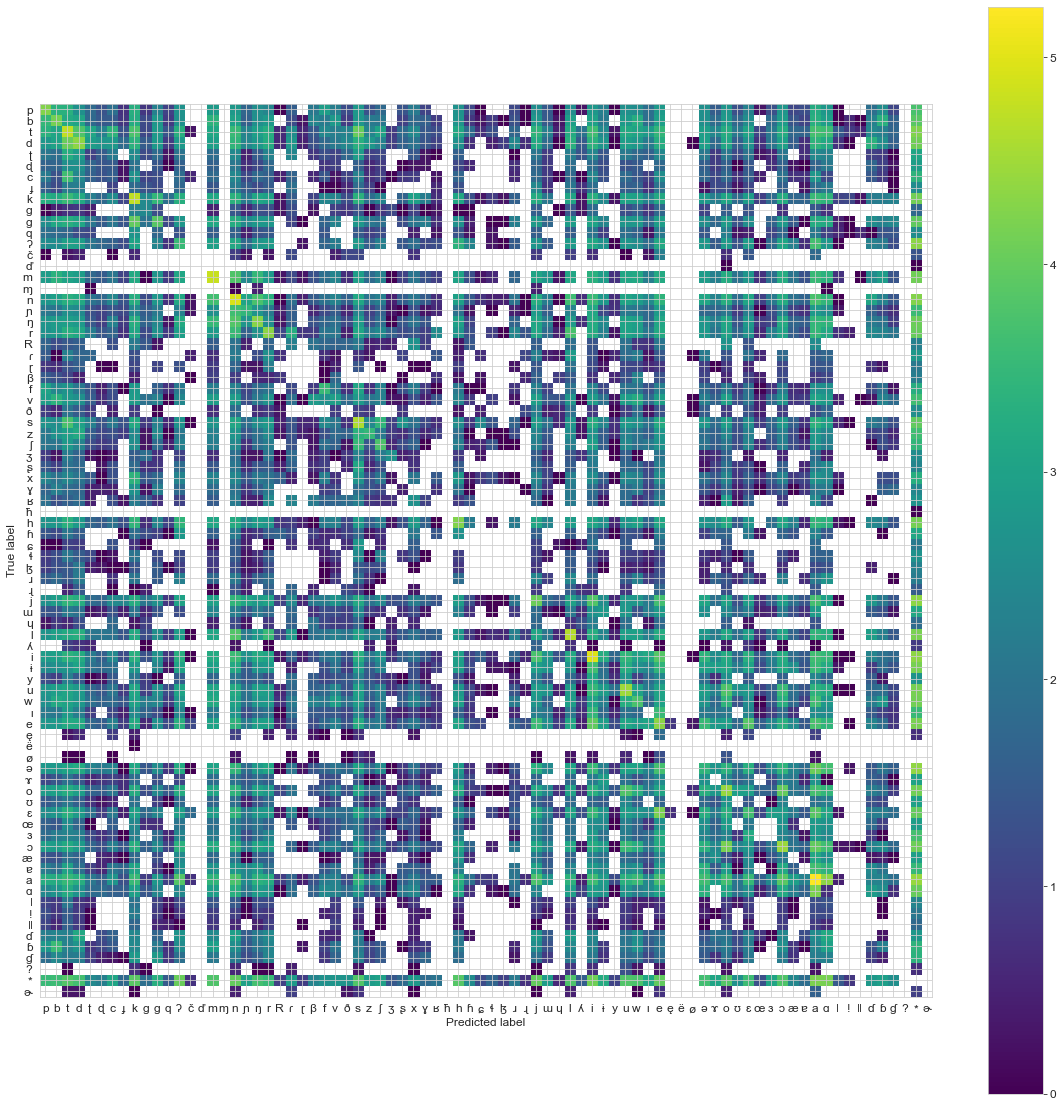

In [44]:
_, ax = plt.subplots(figsize=(20, 20))
#  & lang == "Czech"
places = confs.query('SYSTEM == "e2e_phones" & AM == "cross" & TOKEN_TYPE == "bper"').sort_values(['ref', 'hyp']).groupby(['ref', 'hyp']).sum().reset_index()
symbols = set(places['ref'].unique())
m = to_matrix(places, log=True, norm=False, ref_field='ref', hyp_field='hyp', label_sorting=[p for p in phone_to_manner if p in symbols])
m.plot(include_values=False, ax=ax)

/Users/pzelasko/jhu/alignysis/alignysis/confusions.py:33: RuntimeWarning: divide by zero encountered in log10
  mtx = np.log10(mtx)


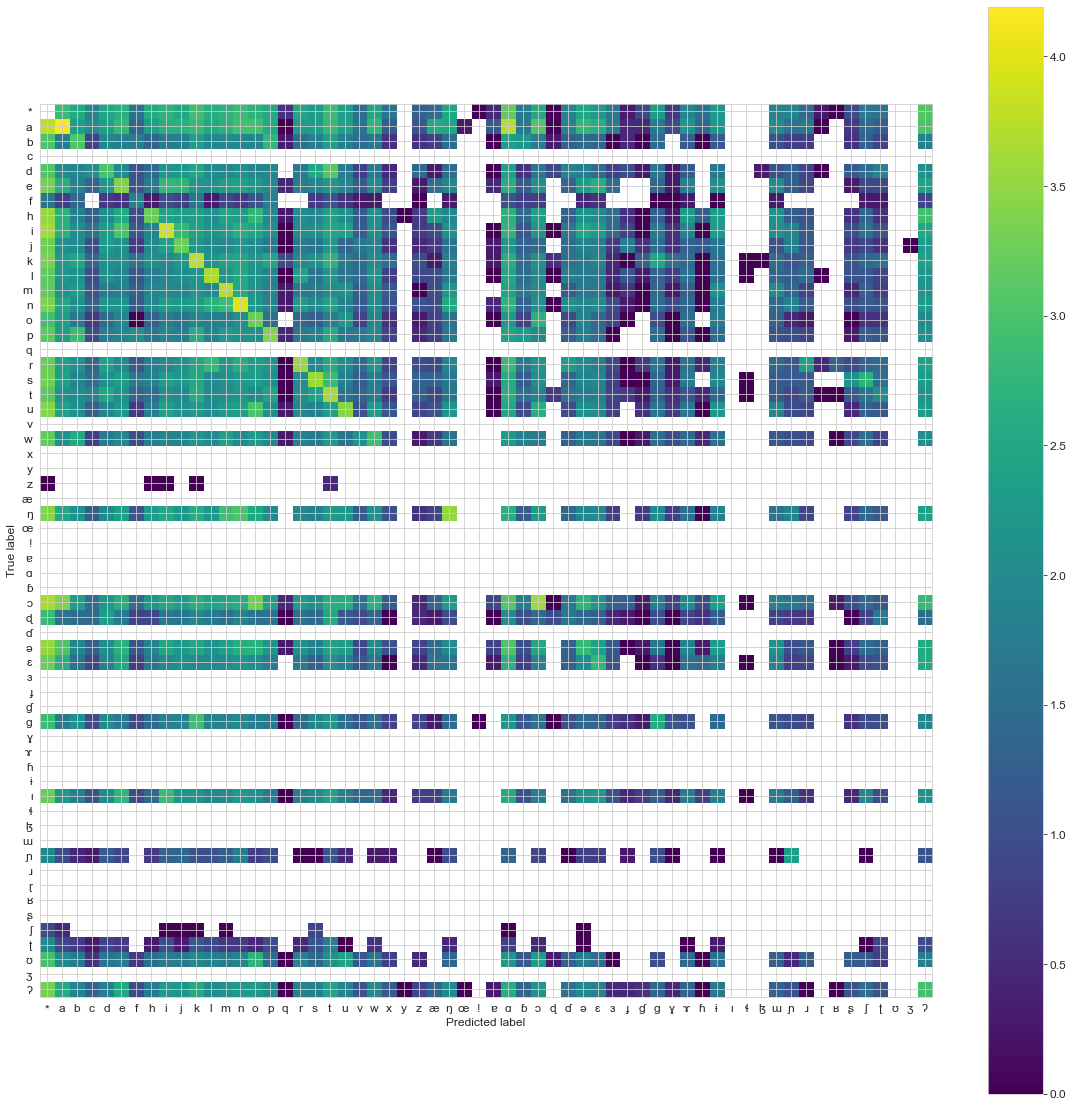

In [67]:
_, ax = plt.subplots(figsize=(20, 20))
places = confs.query('SYSTEM == "e2e_phones" & AM == "cross" & TOKEN_TYPE == "bper" & lang == "Javanese"').sort_values(['ref', 'hyp']).groupby(['ref', 'hyp']).sum().reset_index()
m = to_matrix(places, log=True, norm=False, ref_field='ref', hyp_field='hyp')
m.plot(include_values=False, ax=ax)

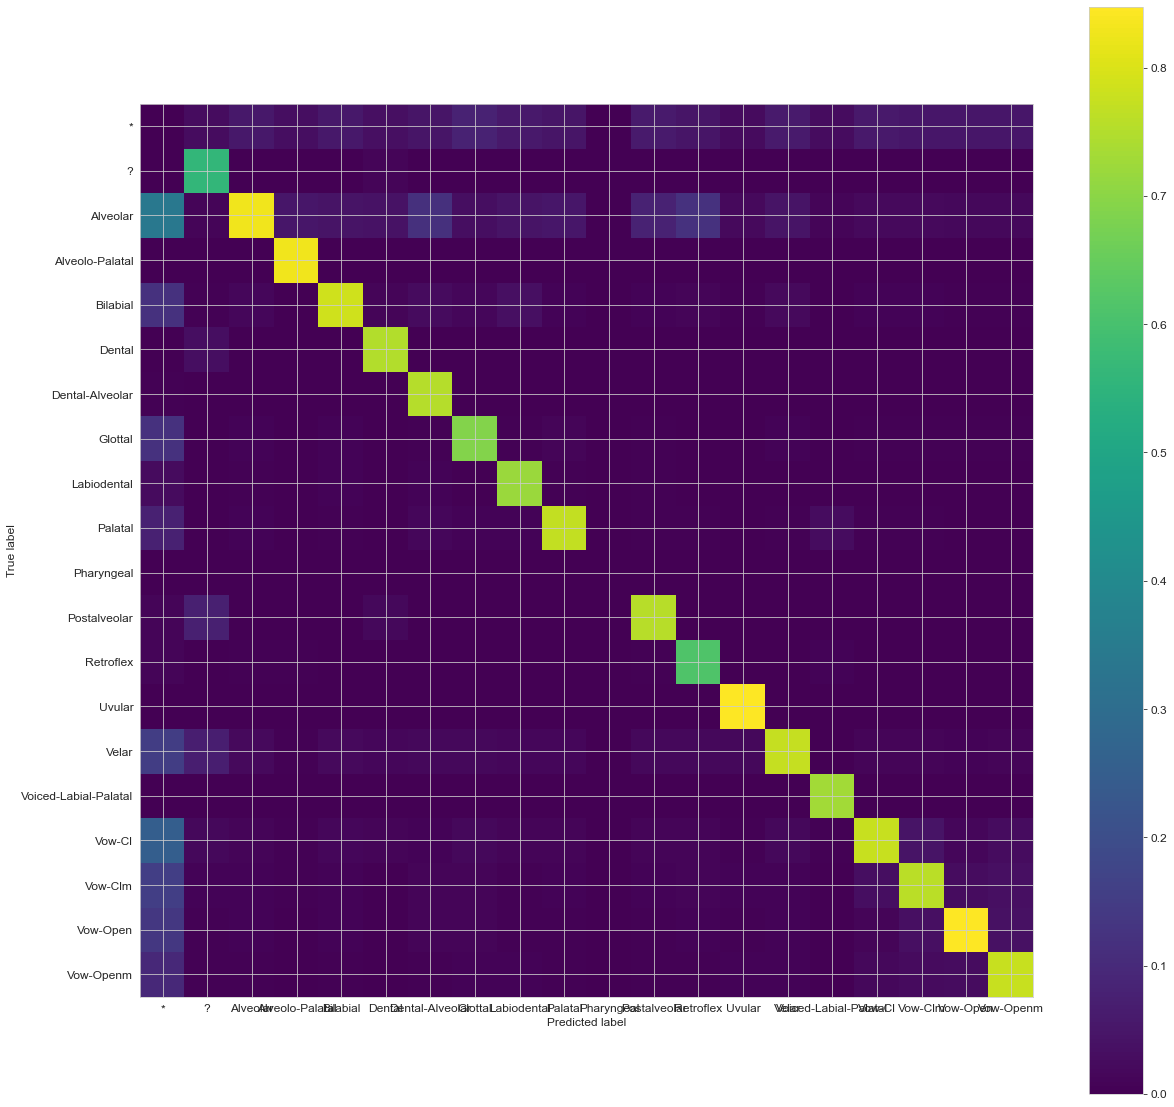

In [68]:
_, ax = plt.subplots(figsize=(20, 20))
places = confs.query('SYSTEM == "e2e_phones" & AM == "multi" & TOKEN_TYPE == "bper"').sort_values(['ref_place', 'hyp_place']).groupby(['ref_place', 'hyp_place']).sum().reset_index()
m = to_matrix(places, log=False, norm=True, ref_field='ref_place', hyp_field='hyp_place')
m.plot(include_values=False, ax=ax)

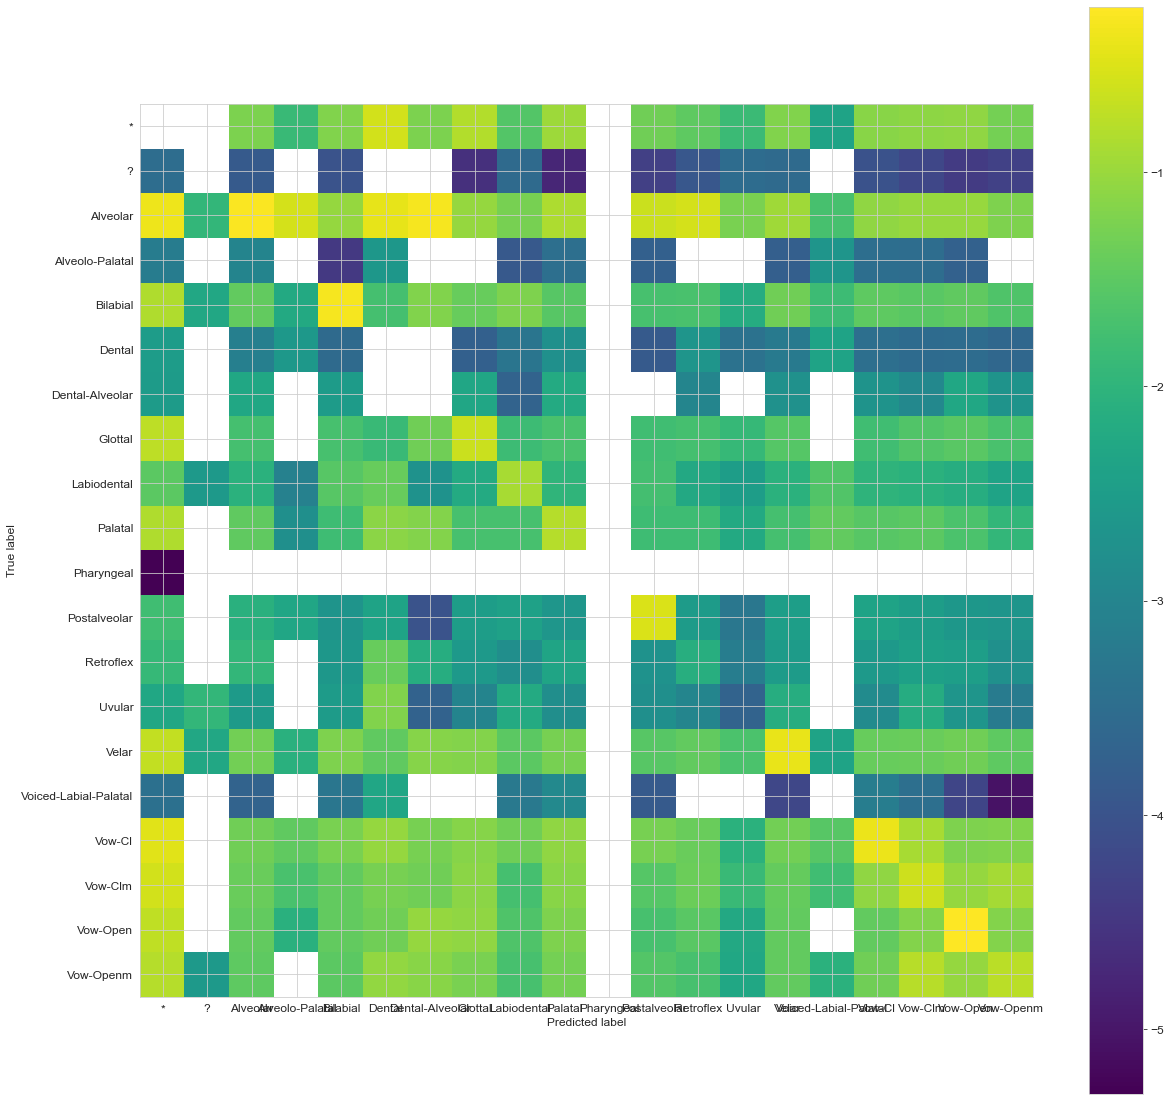

In [69]:
_, ax = plt.subplots(figsize=(20, 20))
places = confs.query('SYSTEM == "e2e_phones" & AM == "cross" & TOKEN_TYPE == "bper"').sort_values(['ref_place', 'hyp_place']).groupby(['ref_place', 'hyp_place']).sum().reset_index()
to_matrix(places, log=True, norm=True, ref_field='ref_place', hyp_field='hyp_place').plot(include_values=False, ax=ax)

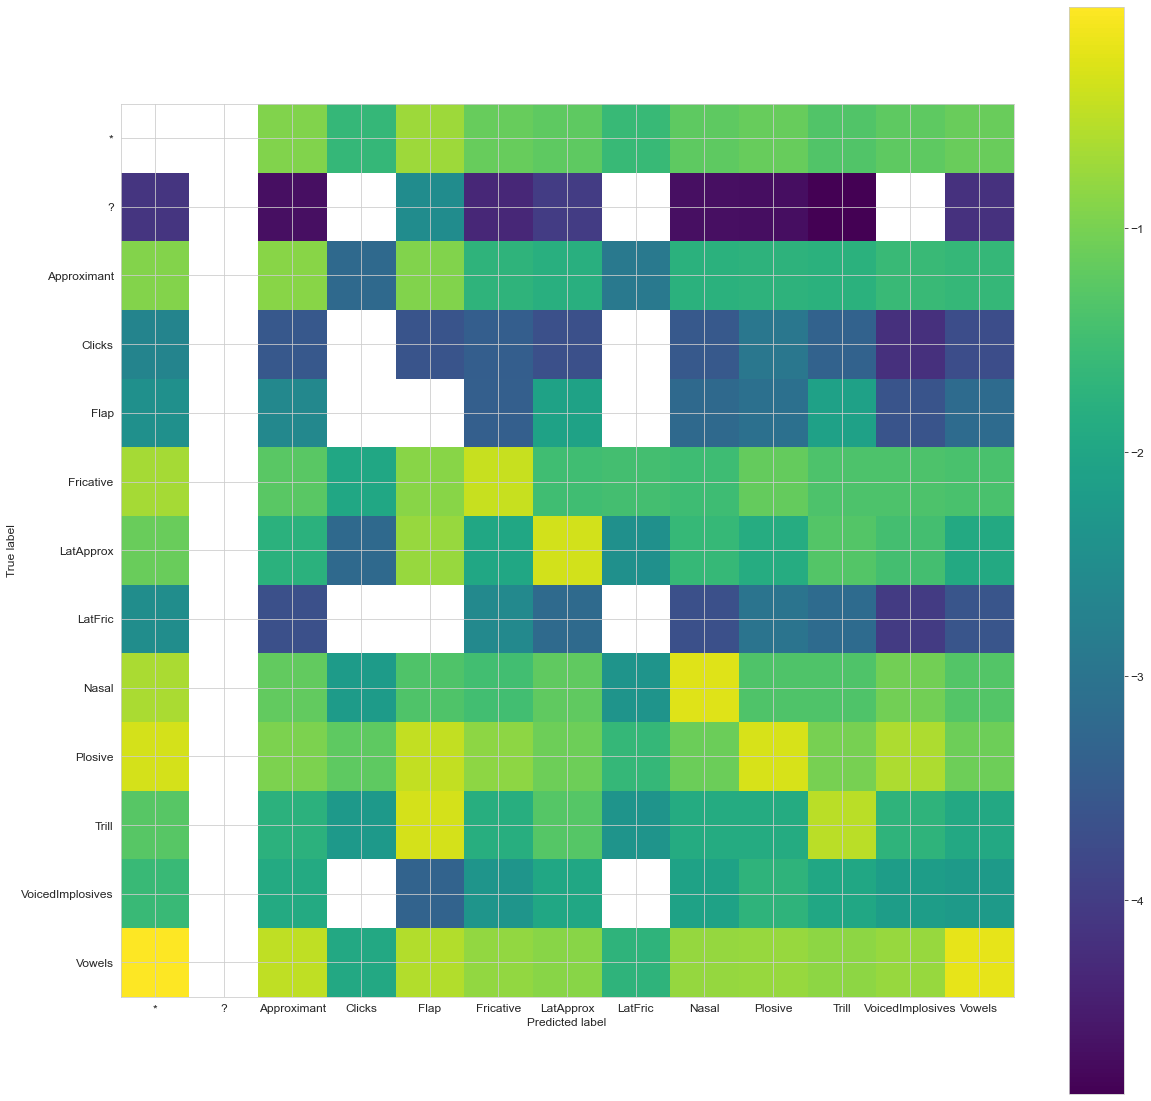

In [70]:
_, ax = plt.subplots(figsize=(20, 20))
manners = confs.query('SYSTEM == "e2e_phones" & AM == "cross" & TOKEN_TYPE == "bper"').sort_values(['ref_manner', 'hyp_manner']).groupby(['ref_manner', 'hyp_manner']).sum().reset_index()
to_matrix(manners, log=True, norm=True, ref_field='ref_manner', hyp_field='hyp_manner').plot(include_values=False, ax=ax)

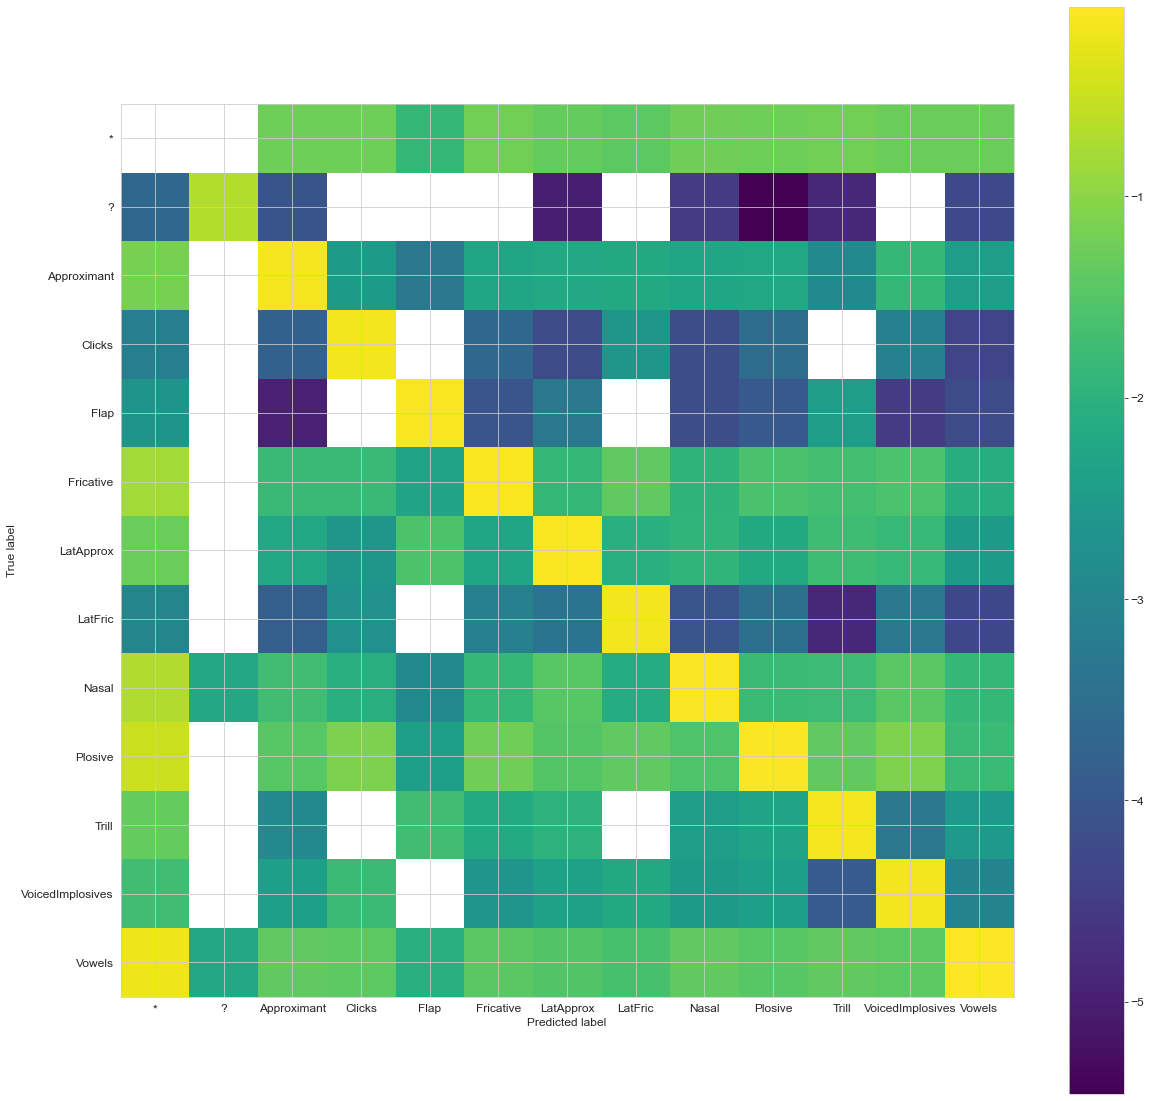

In [71]:
_, ax = plt.subplots(figsize=(20, 20))
manners = confs.query('SYSTEM == "e2e_phones" & AM == "multi" & TOKEN_TYPE == "bper"').sort_values(['ref_manner', 'hyp_manner']).groupby(['ref_manner', 'hyp_manner']).sum().reset_index()
to_matrix(manners, log=True, norm=True, ref_field='ref_manner', hyp_field='hyp_manner').plot(include_values=False, ax=ax)

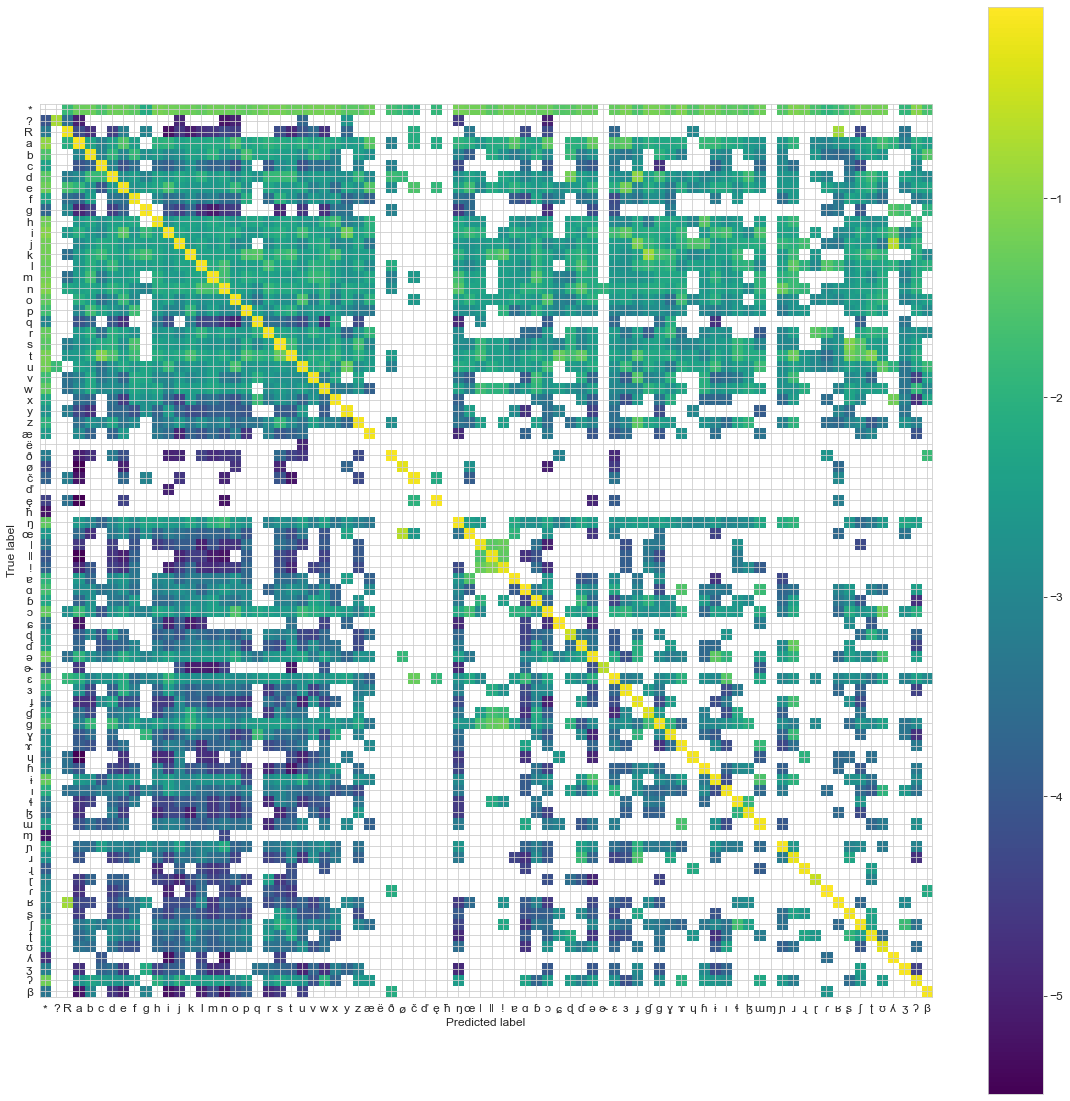

In [72]:
_, ax = plt.subplots(figsize=(20, 20))
to_matrix(confs.query('SYSTEM == "e2e_phones" & AM == "multi" & TOKEN_TYPE == "bper"'), log=True, norm=True).plot(include_values=False, ax=ax)

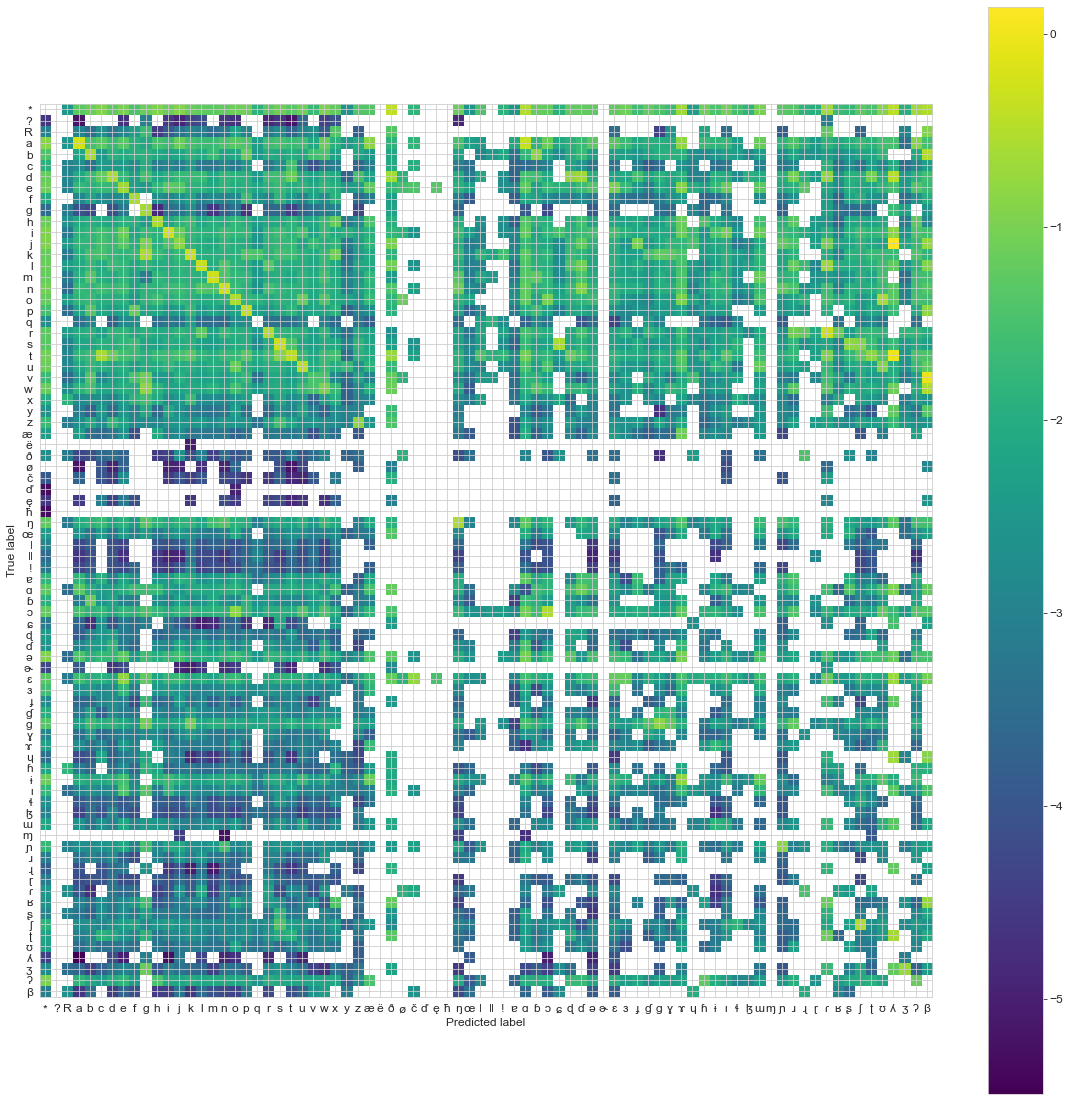

In [73]:
_, ax = plt.subplots(figsize=(20, 20))
to_matrix(confs.query('SYSTEM == "e2e_phones" & AM == "cross" & TOKEN_TYPE == "bper"'), log=True, norm=True).plot(include_values=False, ax=ax)

In [74]:
confs.query('SYSTEM == "e2e_phones" & AM == "cross" & TOKEN_TYPE == "bper"').query('ref != hyp').sort_values(['ref', 'lang', 'count'], ascending=[True, True, False]).groupby(['ref', 'lang']).head(2)

,ref,hyp,count,total_ref,lang,SYSTEM,AM,LM,TOKEN_TYPE,EXP,ref_place,hyp_place,ref_manner,hyp_manner
206,*,i,1013,0,Amharic,e2e_phones,cross,None,bper,e2e_phones_cross_None_bper,*,Vow-Cl,*,Vowels
197,*,a,984,0,Amharic,e2e_phones,cross,None,bper,e2e_phones_cross_None_bper,*,Vow-Open,*,Vowels
494,*,a,2399,0,Bengali,e2e_phones,cross,None,bper,e2e_phones_cross_None_bper,*,Vow-Open,*,Vowels
496,*,i,2242,0,Bengali,e2e_phones,cross,None,bper,e2e_phones_cross_None_bper,*,Vow-Cl,*,Vowels
41,*,ɑ,2966,0,Cantonese,e2e_phones,cross,None,bper,e2e_phones_cross_None_bper,*,Vow-Open,*,Vowels
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,ʔ,a,3271,18087,Lao,e2e_phones,cross,None,bper,e2e_phones_cross_None_bper,Glottal,Vow-Open,Plosive,Vowels
406,ʔ,a,10,52,Thai,e2e_phones,cross,None,bper,e2e_phones_cross_None_bper,Glottal,Vow-Open,Plosive,Vowels
407,ʔ,j,8,52,Thai,e2e_phones,cross,None,bper,e2e_phones_cross_None_bper,Glottal,Palatal,Plosive,Approximant
565,β,w,219,767,Spanish,e2e_phones,cross,None,bper,e2e_phones_cross_None_bper,Bilabial,Vow-Cl,Fricative,Vowels


In [75]:
conf_mat = to_matrix(confs.query('SYSTEM == "e2e_phones" & AM == "cross" & TOKEN_TYPE == "bper"'), log=False, norm=False)
data = conf_mat.confusion_matrix
labels = conf_mat.display_labels

In [76]:
data = symmetrize_confusions(data)
data /= np.sum(data, axis=1)

In [78]:
df.head()

,token,TOTAL_TRUE_COUNT,OK,SUBSTITUTION,DELETION,INSERTION,LANG,SYSTEM,AM,LM,TOKEN_TYPE,EXP
0,w,23242.0,15942.0,4930.0,2370.0,1899.0,Cantonese,e2e_phonetokens,mono,None,per,e2e_phonetokens_mono_None_per
1,ɐ,25332.0,18113.0,5077.0,2142.0,2326.0,Cantonese,e2e_phonetokens,mono,None,per,e2e_phonetokens_mono_None_per
2,j,32180.0,23462.0,5654.0,3064.0,2972.0,Cantonese,e2e_phonetokens,mono,None,per,e2e_phonetokens_mono_None_per
3,˧,53242.0,39745.0,8868.0,4629.0,5139.0,Cantonese,e2e_phonetokens,mono,None,per,e2e_phonetokens_mono_None_per
4,˥,53632.0,41656.0,7627.0,4349.0,5029.0,Cantonese,e2e_phonetokens,mono,None,per,e2e_phonetokens_mono_None_per


In [79]:
df.EXP.unique()

array(['e2e_phonetokens_mono_None_per', 'e2e_phonetokens_multi_None_per',
       'e2e_phonetokens_cross_None_per', 'e2e_phonetokens_mono_None_pter',
       'e2e_phonetokens_multi_None_pter',
       'e2e_phonetokens_cross_None_pter',
       'e2e_phonetokens_mono_None_bper',
       'e2e_phonetokens_multi_None_bper',
       'e2e_phonetokens_cross_None_bper', 'e2e_phones_mono_None_per',
       'e2e_phones_multi_None_per', 'e2e_phones_cross_None_per',
       'e2e_phones_mono_None_pter', 'e2e_phones_multi_None_pter',
       'e2e_phones_cross_None_pter', 'e2e_phones_mono_None_bper',
       'e2e_phones_multi_None_bper', 'e2e_phones_cross_None_bper',
       'hybrid_phones_mono_monolm_phn_ug_per',
       'hybrid_phones_mono_monolm_words_tg_per',
       'hybrid_phones_mono_monolm_per',
       'hybrid_phones_mono_monolm_phn_tg_per',
       'hybrid_phones_multi_multilm_phn_ug_per',
       'hybrid_phones_multi_multiwordslm_per',
       'hybrid_phones_multi_monolm_phn_ug_per',
       'hybrid_phones_m

In [80]:
(df
 .query('TOKEN_TYPE == "per"')
 .groupby('EXP')
 .sum()
 .filter(like='phones', axis=0)
  .filter(like='cross', axis=0)
 .assign(ERRORS=lambda x: x.INSERTION + x.DELETION + x.SUBSTITUTION)
 .assign(ERROR_RATE=lambda x: 100 * x.ERRORS / x.TOTAL_TRUE_COUNT)
 .sort_values('ERROR_RATE')
 .assign(**{
     'INS%': lambda x: 100 * x.INSERTION / x.ERRORS,
     'DEL%': lambda x: 100 * x.DELETION / x.ERRORS,
     'SUB%': lambda x: 100 * x.SUBSTITUTION / x.ERRORS,
 })
 .style.format('{:.1f}')
)

,TOTAL_TRUE_COUNT,OK,SUBSTITUTION,DELETION,INSERTION,ERRORS,ERROR_RATE,INS%,DEL%,SUB%
EXP,,,,,,,,,,
hybrid_phones_cross_monolm_phn_tg_per,2800214.0,798810.0,658301.0,1343103.0,43841.0,2045245.0,73.0,2.1,65.7,32.2
hybrid_phones_cross_monolm_phn_ug_per,2790709.0,557386.0,513020.0,1720303.0,23380.0,2256703.0,80.9,1.0,76.2,22.7
e2e_phones_cross_None_per,2755802.0,677532.0,1661096.0,417174.0,183681.0,2261951.0,82.1,8.1,18.4,73.4
hybrid_phones_cross_crosslm_phn_tg_per,2792723.0,531065.0,1287332.0,974326.0,50327.0,2311985.0,82.8,2.2,42.1,55.7
hybrid_phones_cross_crosslm_per,2789038.0,502353.0,1036915.0,1249770.0,35173.0,2321858.0,83.2,1.5,53.8,44.7
hybrid_phones_cross_crosslm_phn_ug_per,2795615.0,431268.0,748787.0,1615560.0,20080.0,2384427.0,85.3,0.8,67.8,31.4
hybrid_phones_cross_crosslm_words_tg_per,2663864.0,472133.0,1364004.0,827727.0,105581.0,2297312.0,86.2,4.6,36.0,59.4
hybrid_phones_cross_monolm_lowerbound_per,260089.0,31946.0,49907.0,178236.0,1199.0,229342.0,88.2,0.5,77.7,21.8


In [81]:
(df
 .query('TOKEN_TYPE == "pter"')
 .groupby('EXP')
 .sum()
 .filter(like='cross', axis=0)
 .assign(ERRORS=lambda x: x.INSERTION + x.DELETION + x.SUBSTITUTION)
 .assign(ERROR_RATE=lambda x: 100 * x.ERRORS / x.TOTAL_TRUE_COUNT)
 .sort_values('ERROR_RATE')
 .assign(**{
     'INS%': lambda x: 100 * x.INSERTION / x.ERRORS,
     'DEL%': lambda x: 100 * x.DELETION / x.ERRORS,
     'SUB%': lambda x: 100 * x.SUBSTITUTION / x.ERRORS,
 })
 .style.format('{:.1f}')
)

,TOTAL_TRUE_COUNT,OK,SUBSTITUTION,DELETION,INSERTION,ERRORS,ERROR_RATE,INS%,DEL%,SUB%
EXP,,,,,,,,,,
hybrid_phones_cross_monolm_phn_tg_pter,4071557.0,1097590.0,682852.0,2291115.0,43412.0,3017379.0,74.1,1.4,75.9,22.6
e2e_phonetokens_cross_None_pter,3851054.0,1080538.0,1982800.0,787716.0,382047.0,3152563.0,81.9,12.1,25.0,62.9
hybrid_phones_cross_monolm_phn_ug_pter,4126121.0,776694.0,571933.0,2777494.0,41704.0,3391131.0,82.2,1.2,81.9,16.9
hybrid_phones_cross_monolm_lowerbound_pter,630021.0,110798.0,55588.0,463635.0,1756.0,520979.0,82.7,0.3,89.0,10.7
e2e_phones_cross_None_pter,3850170.0,1049871.0,1976474.0,823825.0,404646.0,3204945.0,83.2,12.6,25.7,61.7
hybrid_phones_cross_crosslm_pter,4065658.0,788216.0,1348910.0,1928532.0,128876.0,3406318.0,83.8,3.8,56.6,39.6
hybrid_phones_cross_crosslm_phn_ug_pter,4002518.0,677445.0,913120.0,2411953.0,60253.0,3385326.0,84.6,1.8,71.2,27.0
hybrid_phones_cross_crosslm_phn_tg_pter,4067375.0,855639.0,1668431.0,1543305.0,240181.0,3451917.0,84.9,7.0,44.7,48.3
hybrid_phones_cross_crosslm_words_tg_pter,3805386.0,814892.0,1858632.0,1131862.0,697431.0,3687925.0,96.9,18.9,30.7,50.4


In [26]:
pd.set_option('display.precision', 1)
bper_df = (df
 .query('TOKEN_TYPE == "bper"')
 .fillna({'LM': 'N/A'})
 .sort_values(['SYSTEM', 'AM', 'LM'])
 .groupby(['SYSTEM', 'AM', 'LM'])
 .sum()
 .assign(ERRORS=lambda x: x.INSERTION + x.DELETION + x.SUBSTITUTION)
 .assign(ERROR_RATE=lambda x: 100 * x.ERRORS / x.TOTAL_TRUE_COUNT)
 .sort_values('ERROR_RATE')
 .assign(**{
     'INS%': lambda x: 100 * x.INSERTION / x.ERRORS,
     'DEL%': lambda x: 100 * x.DELETION / x.ERRORS,
     'SUB%': lambda x: 100 * x.SUBSTITUTION / x.ERRORS,
 })
 .astype({
     'TOTAL_TRUE_COUNT': int,
     'OK': int,
     'SUBSTITUTION': int,
     'INSERTION': int,
     'ERRORS': int
 })
 .drop(['TOTAL_TRUE_COUNT', 'OK', 'SUBSTITUTION', 'DELETION', 'INSERTION', 'ERRORS'], axis=1)
 .rename({'ERROR_RATE': 'BPER'}, axis=1)
#  .to_latex()
)

per_df = (df
 .query('TOKEN_TYPE == "per"')
 .fillna({'LM': 'N/A'})
 .sort_values(['SYSTEM', 'AM', 'LM'])
 .groupby(['SYSTEM', 'AM', 'LM'])
 .sum()
 .assign(ERRORS=lambda x: x.INSERTION + x.DELETION + x.SUBSTITUTION)
 .assign(ERROR_RATE=lambda x: 100 * x.ERRORS / x.TOTAL_TRUE_COUNT)
 .sort_values('ERROR_RATE')
#  .assign(**{
#      'INS%': lambda x: 100 * x.INSERTION / x.ERRORS,
#      'DEL%': lambda x: 100 * x.DELETION / x.ERRORS,
#      'SUB%': lambda x: 100 * x.SUBSTITUTION / x.ERRORS,
#  })
 .astype({
     'TOTAL_TRUE_COUNT': int,
     'OK': int,
     'SUBSTITUTION': int,
     'INSERTION': int,
     'ERRORS': int
 })
 .drop(['TOTAL_TRUE_COUNT', 'OK', 'SUBSTITUTION', 'DELETION', 'INSERTION', 'ERRORS'], axis=1)
 .rename({'ERROR_RATE': 'PER'}, axis=1)

#  .to_latex()
)

pter_df = (df
 .query('TOKEN_TYPE == "pter"')
 .fillna({'LM': 'N/A'})
 .sort_values(['SYSTEM', 'AM', 'LM'])
 .groupby(['SYSTEM', 'AM', 'LM'])
 .sum()
 .assign(ERRORS=lambda x: x.INSERTION + x.DELETION + x.SUBSTITUTION)
 .assign(ERROR_RATE=lambda x: 100 * x.ERRORS / x.TOTAL_TRUE_COUNT)
 .sort_values('ERROR_RATE')
#  .assign(**{
#      'INS%': lambda x: 100 * x.INSERTION / x.ERRORS,
#      'DEL%': lambda x: 100 * x.DELETION / x.ERRORS,
#      'SUB%': lambda x: 100 * x.SUBSTITUTION / x.ERRORS,
#  })
 .astype({
     'TOTAL_TRUE_COUNT': int,
     'OK': int,
     'SUBSTITUTION': int,
     'INSERTION': int,
     'ERRORS': int
 })
 .drop(['TOTAL_TRUE_COUNT', 'OK', 'SUBSTITUTION', 'DELETION', 'INSERTION', 'ERRORS'], axis=1)
 .rename({'ERROR_RATE': 'PTER'}, axis=1)

#  .to_latex()
)

print\
(
    pd.merge(pd.merge(per_df, pter_df, left_index=True, right_index=True), bper_df, left_index=True, right_index=True)
    .rename({
        # SYSTEM
        'e2e_phones': 'E-D P',
        'e2e_phonetokens': 'E-D PT',
        'hybrid_phones': 'Hybrid P',
        # LM
        'N/A': '-',
        'monolm_words_tg': 'wtg-mono',
        'multilm_words_tg': 'wtg-multi',
        'monolm_phn_tg': 'tg-mono',
        'monolm': 'bg-mono',
        'multilm': 'bg-multi',
        'multilm_phn_tg': 'tg-multi',
        'monolm_phn_ug': 'ug-mono',
        'multilm_phn_ug': 'ug-multi',
        'crosslm_phn_tg': 'tg-cross',
        'crosslm': 'bg-cross',
        'crosslm_phn_ug': 'ug-cross',
        'crosslm_words_tg': 'tg-cross',
        'monolm_lowerbound': 'wtg-mono'
    })
    .drop([('Hybrid P', 'multi', 'multiwordslm')], axis=0)  # drop multiwordslm
      .to_latex()
)

\begin{tabular}{lllrrrrrr}
\toprule
         &       &          &   PER &  PTER &  BPER &  INS\% &  DEL\% &  SUB\% \\
SYSTEM & AM & LM &       &       &       &       &       &       \\
\midrule
E-D P & multi & - &  31.8 &  29.3 &  29.3 &  19.2 &  29.0 &  51.8 \\
E-D PT & multi & - &  32.4 &  32.4 &  32.0 &  17.8 &  31.7 &  50.5 \\
Hybrid P & mono & wtg-mono &  33.6 &  44.1 &  31.3 &  26.6 &  28.8 &  44.6 \\
         & multi & wtg-mono &  37.2 &  48.8 &  34.7 &  26.8 &  26.3 &  47.0 \\
         &       & wtg-multi &  37.3 &  48.2 &  35.8 &  27.7 &  24.9 &  47.5 \\
         & mono & tg-mono &  38.1 &  36.7 &  35.5 &  11.3 &  44.4 &  44.3 \\
         & multi & tg-mono &  41.0 &  39.9 &  38.0 &  12.9 &  38.8 &  48.3 \\
         & mono & bg-mono &  43.5 &  41.0 &  40.3 &   8.5 &  52.1 &  39.5 \\
         & multi & tg-multi &  43.5 &  40.9 &  39.8 &   9.7 &  44.9 &  45.4 \\
E-D P & mono & - &  43.9 &  39.4 &  41.0 &  16.1 &  28.2 &  55.7 \\
Hybrid P & multi & bg-mono &  45.4 &  43.4 &  41.6

In [82]:
(df
 .query('TOKEN_TYPE == "bper"')
 .groupby('EXP')
 .sum()
 .assign(ERRORS=lambda x: x.INSERTION + x.DELETION + x.SUBSTITUTION)
 .assign(ERROR_RATE=lambda x: 100 * x.ERRORS / x.TOTAL_TRUE_COUNT)
 .sort_values('ERROR_RATE')
 .assign(**{
     'INS%': lambda x: 100 * x.INSERTION / x.ERRORS,
     'DEL%': lambda x: 100 * x.DELETION / x.ERRORS,
     'SUB%': lambda x: 100 * x.SUBSTITUTION / x.ERRORS,
 })
 .style.format('{:.1f}')
)

,TOTAL_TRUE_COUNT,OK,SUBSTITUTION,DELETION,INSERTION,ERRORS,ERROR_RATE,INS%,DEL%,SUB%
EXP,,,,,,,,,,
e2e_phones_multi_None_bper,2755802.0,2102905.0,418283.0,234614.0,154859.0,807756.0,29.3,19.2,29.0,51.8
e2e_phonetokens_multi_None_bper,3851054.0,2922109.0,542516.0,386429.0,236762.0,1165707.0,30.3,20.3,33.1,46.5
hybrid_phones_mono_monolm_words_tg_bper,2675272.0,2064052.0,369976.0,241244.0,222566.0,833786.0,31.2,26.7,28.9,44.4
hybrid_phones_multi_monolm_words_tg_bper,2668546.0,1992307.0,433017.0,243222.0,248591.0,924830.0,34.7,26.9,26.3,46.8
hybrid_phones_mono_monolm_phn_tg_bper,2793979.0,1918668.0,440451.0,434860.0,113821.0,989132.0,35.4,11.5,44.0,44.5
hybrid_phones_multi_multilm_words_tg_bper,2664449.0,1980105.0,449396.0,234948.0,260078.0,944422.0,35.4,27.5,24.9,47.6
hybrid_phones_multi_multiwordslm_bper,2671325.0,1980433.0,453729.0,237163.0,264883.0,955775.0,35.8,27.7,24.8,47.5
hybrid_phones_multi_monolm_phn_tg_bper,2795869.0,1870866.0,519240.0,405763.0,133271.0,1058274.0,37.9,12.6,38.3,49.1
hybrid_phones_multi_multilm_phn_tg_bper,2799112.0,1786977.0,511636.0,500499.0,107609.0,1119744.0,40.0,9.6,44.7,45.7


In [83]:
def per_token_pters(df):
    return 100.0 * pd.DataFrame({
        lang: 
        {
            row['token']: (
                ((row['INSERTION'] or 0.1) + (row['DELETION'] or 0.1) + (row['SUBSTITUTION'] or 0.1)) / (row['TOTAL_TRUE_COUNT'] or 1)
                if row['TOTAL_TRUE_COUNT'] > 50 
                else float('nan')
            )
            for idx, row in dframe.fillna(0).iterrows()
        } 
        for lang, dframe in df.groupby('LANG')
    }).sort_index()

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
pyplot_markers = "ov^<>8spPhH+xXDd"
manner_markers = dict(zip(set(phone_to_manner.values()), pyplot_markers))
manner_markers['?'] = 'd'
place_markers = dict(zip(set(phone_to_place.values()), pyplot_markers))
place_markers['?'] = 'd'